# Deep Learning Project: DUQ
Wendong LIANG, Jingyi LI

## Two Moons

In [ ]:
import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss

import numpy as np
import sklearn.datasets


import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

/Users/jingyili/opt/anaconda3/envs/DL/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class Model_bilinear(nn.Module):
    def __init__(self, features, num_embeddings):
        super().__init__()
        
        self.gamma = 0.999
        self.sigma = 0.3
        
        embedding_size = 10
        
        self.fc1 = nn.Linear(2, features)
        self.fc2 = nn.Linear(features, features)
        self.fc3 = nn.Linear(features, features)
        
        self.W = nn.Parameter(torch.normal(torch.zeros(embedding_size, num_embeddings, features), 1))
        
        self.register_buffer('N', torch.ones(num_embeddings) * 20)
        self.register_buffer('m', torch.normal(torch.zeros(embedding_size, num_embeddings), 1))
        
        self.m = self.m * self.N.unsqueeze(0)

    def embed(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # i is batch, m is embedding_size, n is num_embeddings (classes)
        x = torch.einsum('ij,mnj->imn', x, self.W)
        
        return x

    def bilinear(self, z):
        embeddings = self.m / self.N.unsqueeze(0)
        
        diff = z - embeddings.unsqueeze(0)            
        y_pred = (- diff**2).mean(1).div(2 * self.sigma**2).exp()

        return y_pred

    def forward(self, x):
        z = self.embed(x)
        y_pred = self.bilinear(z)
        
        return z, y_pred

    def update_embeddings(self, x, y):
        z = self.embed(x)
        
        # normalizing value per class, assumes y is one_hot encoded
        self.N = torch.max(self.gamma * self.N + (1 - self.gamma) * y.sum(0), torch.ones_like(self.N))
        
        # compute sum of embeddings on class by class basis
        features_sum = torch.einsum('ijk,ik->jk', z, y)
        
        self.m = self.gamma * self.m + (1 - self.gamma) * features_sum

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

l_gradient_penalty = 1.0

# Moons
noise = 0.1
X_train, y_train = sklearn.datasets.make_moons(n_samples=1500, noise=noise)
X_test, y_test = sklearn.datasets.make_moons(n_samples=200, noise=noise)

num_classes = 2
batch_size = 64

model = Model_bilinear(20, num_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


def calc_gradient_penalty(x, y_pred):
    gradients = torch.autograd.grad(
            outputs=y_pred,
            inputs=x,
            grad_outputs=torch.ones_like(y_pred),
            create_graph=True,
        )[0]


    gradients = gradients.flatten(start_dim=1)
    
    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()
    
    # One sided penalty - down
#     gradient_penalty = F.relu(grad_norm - 1).mean()

    return gradient_penalty


def output_transform_acc(output):
    y_pred, y, x, z = output
    
    y = torch.argmax(y, dim=1)
        
    return y_pred, y


def output_transform_bce(output):
    y_pred, y, x, z = output

    return y_pred, y


def output_transform_gp(output):
    y_pred, y, x, z = output

    return x, y_pred


def step(engine, batch):
    model.train()
    optimizer.zero_grad()
    
    x, y = batch
    x.requires_grad_(True)
    
    z, y_pred = model(x)
    
    loss1 =  F.binary_cross_entropy(y_pred, y)
    loss2 = l_gradient_penalty * calc_gradient_penalty(x, y_pred)
    
    loss = loss1 + loss2
    
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        model.update_embeddings(x, y)
    
    return loss.item()


def eval_step(engine, batch):
    model.eval()

    x, y = batch

    x.requires_grad_(True)

    z, y_pred = model(x)

    return y_pred, y, x, z
    

trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Accuracy(output_transform=output_transform_acc)
metric.attach(evaluator, "accuracy")

metric = Loss(F.binary_cross_entropy, output_transform=output_transform_bce)
metric.attach(evaluator, "bce")

metric = Loss(calc_gradient_penalty, output_transform=output_transform_gp)
metric.attach(evaluator, "gp")


ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), F.one_hot(torch.from_numpy(y_train)).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), F.one_hot(torch.from_numpy(y_test)).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=200, shuffle=False)

@trainer.on(Events.EPOCH_COMPLETED)
def log_results(trainer):
    evaluator.run(dl_test)
    metrics = evaluator.state.metrics

    print("Test Results - Epoch: {} Acc: {:.4f} BCE: {:.2f} GP {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['bce'], metrics['gp']))

In [ ]:
trainer.run(dl_train, max_epochs=30)

Test Results - Epoch: 1 Acc: 0.8500 BCE: 0.52 GP 0.14
Test Results - Epoch: 2 Acc: 0.8850 BCE: 0.35 GP 0.10
Test Results - Epoch: 3 Acc: 0.9200 BCE: 0.34 GP 0.04
Test Results - Epoch: 4 Acc: 0.9600 BCE: 0.19 GP 0.03
Test Results - Epoch: 5 Acc: 0.9850 BCE: 0.13 GP 0.06
Test Results - Epoch: 6 Acc: 0.9900 BCE: 0.13 GP 0.04
Test Results - Epoch: 7 Acc: 0.9950 BCE: 0.11 GP 0.04
Test Results - Epoch: 8 Acc: 1.0000 BCE: 0.10 GP 0.04
Test Results - Epoch: 9 Acc: 0.9950 BCE: 0.10 GP 0.03
Test Results - Epoch: 10 Acc: 1.0000 BCE: 0.09 GP 0.03
Test Results - Epoch: 11 Acc: 0.9950 BCE: 0.09 GP 0.03
Test Results - Epoch: 12 Acc: 0.9950 BCE: 0.09 GP 0.03
Test Results - Epoch: 13 Acc: 0.9950 BCE: 0.09 GP 0.03
Test Results - Epoch: 14 Acc: 0.9950 BCE: 0.09 GP 0.03
Test Results - Epoch: 15 Acc: 1.0000 BCE: 0.09 GP 0.03
Test Results - Epoch: 16 Acc: 1.0000 BCE: 0.09 GP 0.05
Test Results - Epoch: 17 Acc: 1.0000 BCE: 0.08 GP 0.04
Test Results - Epoch: 18 Acc: 0.9950 BCE: 0.08 GP 0.02
Test Results - Epoc

State:
	iteration: 690
	epoch: 30
	epoch_length: 23
	max_epochs: 30
	output: 0.09361258894205093
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

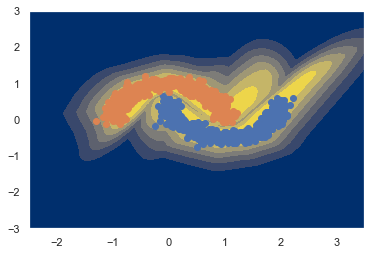

In [ ]:
domain = 3
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=1000, noise=noise)
mask = y_vis.astype(np.bool)

with torch.no_grad():
    output = model(torch.from_numpy(X_grid).float())[1]
    confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1])
plt.scatter(X_vis[~mask,0], X_vis[~mask,1])

## Fashion MNIST vs MNIST

In [ ]:
!pip install pytorch-ignite
import random
import numpy as np

import torch
import torch.utils.data
from torch.nn import functional as F

from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss

from ignite.contrib.handlers.tqdm_logger import ProgressBar

import os
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from scipy.io import loadmat
from PIL import Image
import torch.nn.functional as F
from torch import nn
from sklearn.metrics import roc_auc_score



In [ ]:
#Dataset
def get_MNIST(root="./"):
    input_size = 28
    num_classes = 10
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )

    train_dataset = datasets.MNIST(
        root + "data/", train=True, download=True, transform=transform
    )

    test_dataset = datasets.MNIST(
        root + "data/", train=False, download=True, transform=transform
    )
    return input_size, num_classes, train_dataset, test_dataset


def get_FashionMNIST(root="./"):
    input_size = 28
    num_classes = 10

    transform_list = [transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))]
    transform = transforms.Compose(transform_list)

    train_dataset = datasets.FashionMNIST(
        root + "data/", train=True, download=True, transform=transform
    )
    test_dataset = datasets.FashionMNIST(
        root + "data/", train=False, download=True, transform=transform
    )
    return input_size, num_classes, train_dataset, test_dataset


def get_SVHN(root="./"):
    input_size = 32
    num_classes = 10
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    train_dataset = datasets.SVHN(
        root + "data/SVHN", split="train", transform=transform, download=True
    )
    test_dataset = datasets.SVHN(
        root + "data/SVHN", split="test", transform=transform, download=True
    )
    return input_size, num_classes, train_dataset, test_dataset


def get_CIFAR10(root="./"):
    input_size = 32
    num_classes = 10
    train_transform = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )
    train_dataset = datasets.CIFAR10(
        root + "data/CIFAR10", train=True, transform=train_transform, download=True
    )

    test_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )
    test_dataset = datasets.CIFAR10(
        root + "data/CIFAR10", train=False, transform=test_transform, download=True
    )

    return input_size, num_classes, train_dataset, test_dataset


def get_notMNIST(root="./"):
    input_size = 28
    num_classes = 10

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.4254,), (0.4586,))]
    )

    test_dataset = NotMNIST(root + "data/", transform=transform)

    return input_size, num_classes, None, test_dataset


all_datasets = {
    "MNIST": get_MNIST,
    "notMNIST": get_notMNIST,
    "FashionMNIST": get_FashionMNIST,
    "SVHN": get_SVHN,
    "CIFAR10": get_CIFAR10,
}


class NotMNIST(Dataset):
    def __init__(self, root, transform=None):
        root = os.path.expanduser(root)

        self.transform = transform

        data_dict = loadmat("/content/notMNIST_small_v73.mat")
        #print("mat file:",os.path.join(root, "notMNIST_small.mat"))
        #data_dict = h5py.File(os.path.join(root, "notMNIST_small.mat"))


        self.data = torch.tensor(
            data_dict["images"].transpose(2, 0, 1), dtype=torch.uint8
        ).unsqueeze(1)

        self.targets = torch.tensor(data_dict["labels"], dtype=torch.int64)

    def __getitem__(self, index):
        img = self.data[index]
        target = self.targets[index]

        if self.transform is not None:
            img = Image.fromarray(img.squeeze().numpy(), mode="L")
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.data)


class FastFashionMNIST(datasets.FashionMNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.data = self.data.unsqueeze(1).float().div(255)
        self.data = self.data.sub_(0.2861).div_(0.3530)

        self.data, self.targets = self.data.to("cuda"), self.targets.to("cuda")

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        return img, target

In [ ]:
#evaluate_ood

def prepare_ood_datasets(true_dataset, ood_dataset):
    # Preprocess OoD dataset same as true dataset
    ood_dataset.transform = true_dataset.transform

    datasets = [true_dataset, ood_dataset]

    anomaly_targets = torch.cat(
        (torch.zeros(len(true_dataset)), torch.ones(len(ood_dataset)))
    )

    concat_datasets = torch.utils.data.ConcatDataset(datasets)

    dataloader = torch.utils.data.DataLoader(
        concat_datasets, batch_size=500, shuffle=False, num_workers=4, pin_memory=False
    )

    return dataloader, anomaly_targets


def loop_over_dataloader(model, dataloader):
    model.eval()

    with torch.no_grad():
        scores = []
        accuracies = []
        for data, target in dataloader:
            data = data.cuda()
            target = target.cuda()

            output = model(data)
            kernel_distance, pred = output.max(1)

            accuracy = pred.eq(target)
            #print("accuracy=",accuracy.shape)
            accuracies.append(accuracy.cpu().numpy().flatten())

            scores.append(-kernel_distance.cpu().numpy())

    scores = np.concatenate(scores)
    accuracies = np.concatenate(accuracies)

    return scores, accuracies


def get_auroc_ood(true_dataset, ood_dataset, model):
    dataloader, anomaly_targets = prepare_ood_datasets(true_dataset, ood_dataset)

    scores, accuracies = loop_over_dataloader(model, dataloader)

    accuracy = np.mean(accuracies[: len(true_dataset)])
    roc_auc = roc_auc_score(anomaly_targets, scores)

    return accuracy, roc_auc


def get_auroc_classification(dataset, model):
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=500, shuffle=False, num_workers=4, pin_memory=False
    )

    scores, accuracies = loop_over_dataloader(model, dataloader)

    accuracy = np.mean(accuracies)
    roc_auc = roc_auc_score(1 - accuracies, scores)

    return accuracy, roc_auc


def get_cifar_svhn_ood(model):
    _, _, _, cifar_test_dataset = get_CIFAR10()
    _, _, _, svhn_test_dataset = get_SVHN()

    return get_auroc_ood(cifar_test_dataset, svhn_test_dataset, model)


def get_fashionmnist_mnist_ood(model):
    _, _, _, fashionmnist_test_dataset = get_FashionMNIST()
    _, _, _, mnist_test_dataset = get_MNIST()

    return get_auroc_ood(fashionmnist_test_dataset, mnist_test_dataset, model)


def get_fashionmnist_notmnist_ood(model):
    _, _, _, fashionmnist_test_dataset = get_FashionMNIST()
    _, _, _, notmnist_test_dataset = get_notMNIST()

    return get_auroc_ood(fashionmnist_test_dataset, notmnist_test_dataset, model)


def get_fashionmnist_notmnist_ood(model):
    _, _, _, fashionmnist_test_dataset = get_FashionMNIST()
    _, _, _, notmnist_test_dataset = get_notMNIST()

    return get_auroc_ood(fashionmnist_test_dataset, notmnist_test_dataset, model)


In [ ]:

def train_model(l_gradient_penalty, length_scale, final_model):
    dataset = FastFashionMNIST("data/", train=True, download=True)
    test_dataset = FastFashionMNIST("data/", train=False, download=True)

    idx = list(range(60000))
    random.shuffle(idx)

    if final_model:
        train_dataset = dataset
        val_dataset = test_dataset
    else:
        train_dataset = torch.utils.data.Subset(dataset, indices=idx[:55000])
        val_dataset = torch.utils.data.Subset(dataset, indices=idx[55000:])

    num_classes = 10
    embedding_size = 256
    learnable_length_scale = False
    gamma = 0.999

    model = CNN_DUQ(
        num_classes,
        embedding_size,
        learnable_length_scale,
        length_scale,
        gamma,
    )
    model = model.cuda()

    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4
    )

    def output_transform_bce(output):
        y_pred, y, _, _ = output
        return y_pred, y

    def output_transform_acc(output):
        y_pred, y, _, _ = output
        return y_pred, torch.argmax(y, dim=1)

    def output_transform_gp(output):
        y_pred, y, x, y_pred_sum = output
        return x, y_pred_sum

    def calc_gradient_penalty(x, y_pred_sum):
        gradients = torch.autograd.grad(
            outputs=y_pred_sum,
            inputs=x,
            grad_outputs=torch.ones_like(y_pred_sum),
            create_graph=True,
            retain_graph=True,
        )[0]

        gradients = gradients.flatten(start_dim=1)

        # L2 norm
        grad_norm = gradients.norm(2, dim=1)

        # Two sided penalty
        gradient_penalty = ((grad_norm - 1) ** 2).mean()

        return gradient_penalty

    def step(engine, batch):
        model.train()
        optimizer.zero_grad()

        x, y = batch
        y = F.one_hot(y, num_classes=10).float()

        x, y = x.cuda(), y.cuda()

        x.requires_grad_(True)

        y_pred = model(x)

        loss = F.binary_cross_entropy(y_pred, y)
        loss += l_gradient_penalty * calc_gradient_penalty(x, y_pred.sum(1))

        x.requires_grad_(False)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            model.update_embeddings(x, y)

        return loss.item()

    def eval_step(engine, batch):
        model.eval()

        x, y = batch
        y = F.one_hot(y, num_classes=10).float()

        x, y = x.cuda(), y.cuda()

        x.requires_grad_(True)

        y_pred = model(x)

        return y_pred, y, x, y_pred.sum(1)

    trainer = Engine(step)
    evaluator = Engine(eval_step)

    metric = Accuracy(output_transform=output_transform_acc)
    metric.attach(evaluator, "accuracy")

    metric = Loss(F.binary_cross_entropy, output_transform=output_transform_bce)
    metric.attach(evaluator, "bce")

    metric = Loss(calc_gradient_penalty, output_transform=output_transform_gp)
    metric.attach(evaluator, "gradient_penalty")

    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[10, 20], gamma=0.2
    )

    dl_train = torch.utils.data.DataLoader(
        train_dataset, batch_size=128, shuffle=True, num_workers=0, drop_last=True
    )

    dl_val = torch.utils.data.DataLoader(
        val_dataset, batch_size=2000, shuffle=False, num_workers=0
    )

    dl_test = torch.utils.data.DataLoader(
        test_dataset, batch_size=2000, shuffle=False, num_workers=0
    )

    pbar = ProgressBar()
    pbar.attach(trainer)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_results(trainer):
        scheduler.step()

        if trainer.state.epoch % 5 == 0:
            evaluator.run(dl_val)
            _, roc_auc_mnist = get_fashionmnist_mnist_ood(model)
            _, roc_auc_notmnist = get_fashionmnist_notmnist_ood(model)

            metrics = evaluator.state.metrics

            print(
                f"Validation Results - Epoch: {trainer.state.epoch} "
                f"Acc: {metrics['accuracy']:.4f} "
                f"BCE: {metrics['bce']:.2f} "
                f"GP: {metrics['gradient_penalty']:.6f} "
                f"AUROC MNIST: {roc_auc_mnist:.2f} "
                f"AUROC NotMNIST: {roc_auc_notmnist:.2f} "
            )
            print(f"Sigma: {model.sigma}")

    trainer.run(dl_train, max_epochs=30)

    evaluator.run(dl_val)
    val_accuracy = evaluator.state.metrics["accuracy"]

    evaluator.run(dl_test)
    test_accuracy = evaluator.state.metrics["accuracy"]

    return model, val_accuracy, test_accuracy


In [ ]:
#cnn_duq
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(2 * 2 * 128, 256)

    def compute_features(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)

        x = x.flatten(1)

        x = F.relu(self.fc1(x))

        return x


class CNN_DUQ(Model):
    def __init__(
        self,
        num_classes,
        embedding_size,
        learnable_length_scale,
        length_scale,
        gamma,
    ):
        super().__init__()

        self.gamma = gamma

        self.W = nn.Parameter(
            torch.normal(torch.zeros(embedding_size, num_classes, 256), 0.05)
        )

        self.register_buffer("N", torch.ones(num_classes) * 12)
        self.register_buffer(
            "m", torch.normal(torch.zeros(embedding_size, num_classes), 1)
        )

        self.m = self.m * self.N.unsqueeze(0)

        if learnable_length_scale:
            self.sigma = nn.Parameter(torch.zeros(num_classes) + length_scale)
        else:
            self.sigma = length_scale

    def update_embeddings(self, x, y):
        z = self.last_layer(self.compute_features(x))

        # normalizing value per class, assumes y is one_hot encoded
        self.N = self.gamma * self.N + (1 - self.gamma) * y.sum(0)

        # compute sum of embeddings on class by class basis
        features_sum = torch.einsum("ijk,ik->jk", z, y)

        self.m = self.gamma * self.m + (1 - self.gamma) * features_sum

    def last_layer(self, z):
        z = torch.einsum("ij,mnj->imn", z, self.W)
        return z

    def output_layer(self, z):
        embeddings = self.m / self.N.unsqueeze(0)

        diff = z - embeddings.unsqueeze(0)
        distances = (-(diff**2)).mean(1).div(2 * self.sigma**2).exp()

        return distances

    def forward(self, x):
        z = self.last_layer(self.compute_features(x))
        y_pred = self.output_layer(z)

        return y_pred


class SoftmaxModel(Model):
    def __init__(self, input_size, num_classes):
        super().__init__()

        self.last_layer = nn.Linear(256, num_classes)
        self.output_layer = nn.LogSoftmax(dim=1)

    def forward(self, x):
        z = self.last_layer(self.compute_features(x))
        y_pred = F.log_softmax(z, dim=1)

        return y_pred

In [ ]:
_, _, _, fashionmnist_test_dataset = get_FashionMNIST()

# Finding length scale - decided based on validation accuracy
#l_gradient_penalties = [0.0]
#length_scales = [0.05, 0.1, 0.2, 0.3, 0.5, 1.0]

# Finding gradient penalty - decided based on AUROC on NotMNIST
# l_gradient_penalties = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]
# length_scales = [0.1]

#use best hyper parameters
l_gradient_penalties = [0.05]
length_scales = [0.1]


repetition = 1  # Increase for multiple repetitions
final_model = False  # set true for final model to train on full train set

results = {}

for l_gradient_penalty in l_gradient_penalties:
    for length_scale in length_scales:
        val_accuracies = []
        test_accuracies = []
        roc_aucs_mnist = []
        roc_aucs_notmnist = []

        for _ in range(repetition):
            print(" ### NEW MODEL ### ")
            model, val_accuracy, test_accuracy = train_model(
                l_gradient_penalty, length_scale, final_model
            )
            accuracy, roc_auc_mnist = get_fashionmnist_mnist_ood(model)
            _, roc_auc_notmnist = get_fashionmnist_notmnist_ood(model)

            val_accuracies.append(val_accuracy)
            test_accuracies.append(test_accuracy)
            roc_aucs_mnist.append(roc_auc_mnist)
            roc_aucs_notmnist.append(roc_auc_notmnist)

        results[f"lgp{l_gradient_penalty}_ls{length_scale}"] = [
            (np.mean(val_accuracies), np.std(val_accuracies)),
            (np.mean(test_accuracies), np.std(test_accuracies)),
            (np.mean(roc_aucs_mnist), np.std(roc_aucs_mnist)),
            (np.mean(roc_aucs_notmnist), np.std(roc_aucs_notmnist)),
        ]
        print(results[f"lgp{l_gradient_penalty}_ls{length_scale}"])

print(results)


 ### NEW MODEL ### 


[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

Validation Results - Epoch: 5 Acc: 0.9068 BCE: 0.05 GP: 0.273082 AUROC MNIST: 0.90 AUROC NotMNIST: 0.95 
Sigma: 0.1


[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

Validation Results - Epoch: 10 Acc: 0.9184 BCE: 0.05 GP: 0.324993 AUROC MNIST: 0.96 AUROC NotMNIST: 0.97 
Sigma: 0.1


[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

Validation Results - Epoch: 15 Acc: 0.9278 BCE: 0.04 GP: 0.360661 AUROC MNIST: 0.94 AUROC NotMNIST: 0.97 
Sigma: 0.1


[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

Validation Results - Epoch: 20 Acc: 0.9258 BCE: 0.04 GP: 0.354427 AUROC MNIST: 0.95 AUROC NotMNIST: 0.97 
Sigma: 0.1


[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

Validation Results - Epoch: 25 Acc: 0.9276 BCE: 0.04 GP: 0.359639 AUROC MNIST: 0.95 AUROC NotMNIST: 0.97 
Sigma: 0.1


[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

[1/429]   0%|           [00:00<?]

Validation Results - Epoch: 30 Acc: 0.9284 BCE: 0.04 GP: 0.349570 AUROC MNIST: 0.95 AUROC NotMNIST: 0.97 
Sigma: 0.1
[(0.9284, 0.0), (0.9224, 0.0), (0.9503671, 0.0), (0.9680985232856226, 0.0)]
{'lgp0.05_ls0.1': [(0.9284, 0.0), (0.9224, 0.0), (0.9503671, 0.0), (0.9680985232856226, 0.0)]}


## CIFAR-10 vs SVHN

### reproduction $\lambda=0$


In [ ]:
architecture="ResNet18" #or "WRN"
batch_size=128
length_scale=0.1     #"Length scale of RBF kernel (default: 0.1)",
centroid_size=None
learning_rate=0.05
l_gradient_penalty=0
gamma=0.999 #Decay factor for exponential average
weight_decay=5e-4
final_model=True
output_dir="results"

writer = SummaryWriter(log_dir=f"runs/{output_dir}")

ds = all_datasets["CIFAR10"]()
input_size, num_classes, dataset, test_dataset = ds

idx = list(range(len(dataset)))
random.shuffle(idx)

if final_model:
    train_dataset = dataset
    val_dataset = test_dataset
else:
    val_size = int(len(dataset) * 0.8)
    train_dataset = torch.utils.data.Subset(dataset, idx[:val_size])
    val_dataset = torch.utils.data.Subset(dataset, idx[val_size:])

    val_dataset.transform = (
        test_dataset.transform
    )  # Test time preprocessing for validation

if architecture == "WRN":
    model_output_size = 640
    epochs = 200
    milestones = [60, 120, 160]
    feature_extractor = WideResNet()
elif architecture == "ResNet18":
    model_output_size = 512
    epochs = 100
    milestones = [25, 50, 75]
    feature_extractor = resnet18()

    # Adapted resnet from:
    # https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
    feature_extractor.conv1 = torch.nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )
    feature_extractor.maxpool = torch.nn.Identity()
    feature_extractor.fc = torch.nn.Identity()
elif architecture == "ResNet34":
    model_output_size = 512
    epochs = 100
    milestones = [25, 50, 75]
    feature_extractor = resnet34()
    feature_extractor.conv1 = torch.nn.Conv2d(
        3, 64, kernel_size=2, stride=1, padding=1, bias=False
    )
    feature_extractor.maxpool = torch.nn.Identity()
    feature_extractor.fc = torch.nn.Identity()
if centroid_size is None:
    centroid_size = model_output_size

model = ResNet_DUQ(
    feature_extractor,
    num_classes,
    centroid_size,
    model_output_size,
    length_scale,
    gamma,
)
model = model.cuda()

optimizer = torch.optim.SGD(    model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=milestones, gamma=0.2
)

def calc_gradients_input(x, y_pred):
    gradients = torch.autograd.grad(
        outputs=y_pred,
        inputs=x,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True,
    )[0]

    gradients = gradients.flatten(start_dim=1)

    return gradients

def calc_gradient_penalty(x, y_pred):
    gradients = calc_gradients_input(x, y_pred)

    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()

    return gradient_penalty

def step(engine, batch):
    model.train()

    optimizer.zero_grad()

    x, y = batch
    x, y = x.cuda(), y.cuda()

    x.requires_grad_(True)

    y_pred = model(x)

    y = F.one_hot(y, num_classes).float()

    loss = F.binary_cross_entropy(y_pred, y, reduction="mean")

    if l_gradient_penalty > 0:
        gp = calc_gradient_penalty(x, y_pred)
        loss += l_gradient_penalty * gp

    loss.backward()
    optimizer.step()

    x.requires_grad_(False)

    with torch.no_grad():
        model.eval()
        model.update_embeddings(x, y)

    return loss.item()

def eval_step(engine, batch):
    model.eval()

    x, y = batch
    x, y = x.cuda(), y.cuda()

    x.requires_grad_(True)

    y_pred = model(x)

    return {"x": x, "y": y, "y_pred": y_pred}

trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Average()
metric.attach(trainer, "loss")

metric = Accuracy(output_transform=lambda out: (out["y_pred"], out["y"]))
metric.attach(evaluator, "accuracy")

def bce_output_transform(out):
    return (out["y_pred"], F.one_hot(out["y"], num_classes).float())

metric = Loss(F.binary_cross_entropy, output_transform=bce_output_transform)
metric.attach(evaluator, "bce")

metric = Loss(
    calc_gradient_penalty, output_transform=lambda out: (out["x"], out["y_pred"])
)
metric.attach(evaluator, "gradient_penalty")

pbar = ProgressBar(dynamic_ncols=True)
pbar.attach(trainer)

kwargs = {"num_workers": 4, "pin_memory": True}

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, **kwargs
)


@trainer.on(Events.EPOCH_COMPLETED)
def log_results(trainer):
    metrics = trainer.state.metrics
    loss = metrics["loss"]

    print(f"Train - Epoch: {trainer.state.epoch} Loss: {loss:.2f}")

    writer.add_scalar("Loss/train", loss, trainer.state.epoch)

    if trainer.state.epoch > (epochs - 5):

        accuracy, auroc = get_cifar_svhn_ood(model)
        print(f"Test Accuracy: {accuracy}, AUROC: {auroc}")
        writer.add_scalar("OoD/test_accuracy", accuracy, trainer.state.epoch)
        writer.add_scalar("OoD/roc_auc", auroc, trainer.state.epoch)

        accuracy, auroc = get_auroc_classification(val_dataset, model)
        print(f"AUROC - uncertainty: {auroc}")
        writer.add_scalar("OoD/val_accuracy", accuracy, trainer.state.epoch)
        writer.add_scalar("OoD/roc_auc_classification", auroc, trainer.state.epoch)

    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    acc = metrics["accuracy"]
    bce = metrics["bce"]
    GP = metrics["gradient_penalty"]
    loss = bce + l_gradient_penalty * GP

    print(
        (
            f"Valid - Epoch: {trainer.state.epoch} "
            f"Acc: {acc:.4f} "
            f"Loss: {loss:.2f} "
            f"BCE: {bce:.2f} "
            f"GP: {GP:.2f} "
        )
    )

    writer.add_scalar("Loss/valid", loss, trainer.state.epoch)
    writer.add_scalar("BCE/valid", bce, trainer.state.epoch)
    writer.add_scalar("GP/valid", GP, trainer.state.epoch)
    writer.add_scalar("Accuracy/valid", acc, trainer.state.epoch)

    scheduler.step()

trainer.run(train_loader, max_epochs=epochs)




  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1/390]   0%|           [00:00<?]

Train - Epoch: 1 Loss: 0.25
Valid - Epoch: 1 Acc: 0.4880 Loss: 0.22 BCE: 0.22 GP: 0.67 


[1/390]   0%|           [00:00<?]

Train - Epoch: 2 Loss: 0.19
Valid - Epoch: 2 Acc: 0.6369 Loss: 0.17 BCE: 0.17 GP: 0.74 


[1/390]   0%|           [00:00<?]

Train - Epoch: 3 Loss: 0.16
Valid - Epoch: 3 Acc: 0.6915 Loss: 0.15 BCE: 0.15 GP: 0.75 


[1/390]   0%|           [00:00<?]

Train - Epoch: 4 Loss: 0.14
Valid - Epoch: 4 Acc: 0.7286 Loss: 0.13 BCE: 0.13 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 5 Loss: 0.12
Valid - Epoch: 5 Acc: 0.7289 Loss: 0.13 BCE: 0.13 GP: 0.75 


[1/390]   0%|           [00:00<?]

Train - Epoch: 6 Loss: 0.11
Valid - Epoch: 6 Acc: 0.7584 Loss: 0.12 BCE: 0.12 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 7 Loss: 0.10
Valid - Epoch: 7 Acc: 0.7901 Loss: 0.10 BCE: 0.10 GP: 0.75 


[1/390]   0%|           [00:00<?]

Train - Epoch: 8 Loss: 0.09
Valid - Epoch: 8 Acc: 0.7684 Loss: 0.12 BCE: 0.12 GP: 0.74 


[1/390]   0%|           [00:00<?]

Train - Epoch: 9 Loss: 0.08
Valid - Epoch: 9 Acc: 0.8124 Loss: 0.10 BCE: 0.10 GP: 0.78 


[1/390]   0%|           [00:00<?]

Train - Epoch: 10 Loss: 0.08
Valid - Epoch: 10 Acc: 0.8332 Loss: 0.09 BCE: 0.09 GP: 0.76 


[1/390]   0%|           [00:00<?]

Train - Epoch: 11 Loss: 0.07
Valid - Epoch: 11 Acc: 0.8346 Loss: 0.08 BCE: 0.08 GP: 0.79 


[1/390]   0%|           [00:00<?]

Train - Epoch: 12 Loss: 0.07
Valid - Epoch: 12 Acc: 0.8329 Loss: 0.08 BCE: 0.08 GP: 0.79 


[1/390]   0%|           [00:00<?]

Train - Epoch: 13 Loss: 0.07
Valid - Epoch: 13 Acc: 0.8335 Loss: 0.09 BCE: 0.09 GP: 0.78 


[1/390]   0%|           [00:00<?]

Train - Epoch: 14 Loss: 0.06
Valid - Epoch: 14 Acc: 0.8280 Loss: 0.09 BCE: 0.09 GP: 0.78 


[1/390]   0%|           [00:00<?]

Train - Epoch: 15 Loss: 0.06
Valid - Epoch: 15 Acc: 0.8415 Loss: 0.08 BCE: 0.08 GP: 0.79 


[1/390]   0%|           [00:00<?]

Train - Epoch: 16 Loss: 0.06
Valid - Epoch: 16 Acc: 0.8077 Loss: 0.10 BCE: 0.10 GP: 0.78 


[1/390]   0%|           [00:00<?]

Train - Epoch: 17 Loss: 0.06
Valid - Epoch: 17 Acc: 0.8529 Loss: 0.08 BCE: 0.08 GP: 0.76 


[1/390]   0%|           [00:00<?]

Train - Epoch: 18 Loss: 0.06
Valid - Epoch: 18 Acc: 0.8524 Loss: 0.08 BCE: 0.08 GP: 0.77 


[1/390]   0%|           [00:00<?]

Train - Epoch: 19 Loss: 0.06
Valid - Epoch: 19 Acc: 0.8481 Loss: 0.08 BCE: 0.08 GP: 0.77 


[1/390]   0%|           [00:00<?]

Train - Epoch: 20 Loss: 0.05
Valid - Epoch: 20 Acc: 0.8417 Loss: 0.08 BCE: 0.08 GP: 0.74 


[1/390]   0%|           [00:00<?]

Train - Epoch: 21 Loss: 0.05
Valid - Epoch: 21 Acc: 0.8440 Loss: 0.08 BCE: 0.08 GP: 0.76 


[1/390]   0%|           [00:00<?]

Train - Epoch: 22 Loss: 0.05
Valid - Epoch: 22 Acc: 0.8383 Loss: 0.08 BCE: 0.08 GP: 0.75 


[1/390]   0%|           [00:00<?]

Train - Epoch: 23 Loss: 0.05
Valid - Epoch: 23 Acc: 0.8576 Loss: 0.07 BCE: 0.07 GP: 0.74 


[1/390]   0%|           [00:00<?]

Train - Epoch: 24 Loss: 0.05
Valid - Epoch: 24 Acc: 0.8563 Loss: 0.08 BCE: 0.08 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 25 Loss: 0.05
Valid - Epoch: 25 Acc: 0.8472 Loss: 0.08 BCE: 0.08 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 26 Loss: 0.03
Valid - Epoch: 26 Acc: 0.9251 Loss: 0.04 BCE: 0.04 GP: 0.81 


[1/390]   0%|           [00:00<?]

Train - Epoch: 27 Loss: 0.02
Valid - Epoch: 27 Acc: 0.9281 Loss: 0.04 BCE: 0.04 GP: 0.81 


[1/390]   0%|           [00:00<?]

Train - Epoch: 28 Loss: 0.02
Valid - Epoch: 28 Acc: 0.9304 Loss: 0.04 BCE: 0.04 GP: 0.81 


[1/390]   0%|           [00:00<?]

Train - Epoch: 29 Loss: 0.02
Valid - Epoch: 29 Acc: 0.9295 Loss: 0.04 BCE: 0.04 GP: 0.81 


[1/390]   0%|           [00:00<?]

Train - Epoch: 30 Loss: 0.02
Valid - Epoch: 30 Acc: 0.9277 Loss: 0.04 BCE: 0.04 GP: 0.81 


[1/390]   0%|           [00:00<?]

Train - Epoch: 31 Loss: 0.01
Valid - Epoch: 31 Acc: 0.9316 Loss: 0.04 BCE: 0.04 GP: 0.81 


[1/390]   0%|           [00:00<?]

Train - Epoch: 32 Loss: 0.01
Valid - Epoch: 32 Acc: 0.9275 Loss: 0.04 BCE: 0.04 GP: 0.82 


[1/390]   0%|           [00:00<?]

Train - Epoch: 33 Loss: 0.01
Valid - Epoch: 33 Acc: 0.9256 Loss: 0.04 BCE: 0.04 GP: 0.82 


[1/390]   0%|           [00:00<?]

Train - Epoch: 34 Loss: 0.01
Valid - Epoch: 34 Acc: 0.9235 Loss: 0.04 BCE: 0.04 GP: 0.83 


[1/390]   0%|           [00:00<?]

Train - Epoch: 35 Loss: 0.01
Valid - Epoch: 35 Acc: 0.9211 Loss: 0.05 BCE: 0.05 GP: 0.80 


[1/390]   0%|           [00:00<?]

Train - Epoch: 36 Loss: 0.01
Valid - Epoch: 36 Acc: 0.9181 Loss: 0.05 BCE: 0.05 GP: 0.80 


[1/390]   0%|           [00:00<?]

Train - Epoch: 37 Loss: 0.01
Valid - Epoch: 37 Acc: 0.9285 Loss: 0.04 BCE: 0.04 GP: 0.82 


[1/390]   0%|           [00:00<?]

Train - Epoch: 38 Loss: 0.01
Valid - Epoch: 38 Acc: 0.9234 Loss: 0.04 BCE: 0.04 GP: 0.83 


[1/390]   0%|           [00:00<?]

Train - Epoch: 39 Loss: 0.01
Valid - Epoch: 39 Acc: 0.9232 Loss: 0.04 BCE: 0.04 GP: 0.83 


[1/390]   0%|           [00:00<?]

Train - Epoch: 40 Loss: 0.01
Valid - Epoch: 40 Acc: 0.9178 Loss: 0.05 BCE: 0.05 GP: 0.81 


[1/390]   0%|           [00:00<?]

Train - Epoch: 41 Loss: 0.01
Valid - Epoch: 41 Acc: 0.9209 Loss: 0.05 BCE: 0.05 GP: 0.83 


[1/390]   0%|           [00:00<?]

Train - Epoch: 42 Loss: 0.01
Valid - Epoch: 42 Acc: 0.9177 Loss: 0.05 BCE: 0.05 GP: 0.83 


[1/390]   0%|           [00:00<?]

Train - Epoch: 43 Loss: 0.01
Valid - Epoch: 43 Acc: 0.9012 Loss: 0.06 BCE: 0.06 GP: 0.80 


[1/390]   0%|           [00:00<?]

Train - Epoch: 44 Loss: 0.01
Valid - Epoch: 44 Acc: 0.9226 Loss: 0.05 BCE: 0.05 GP: 0.83 


[1/390]   0%|           [00:00<?]

Train - Epoch: 45 Loss: 0.01
Valid - Epoch: 45 Acc: 0.9233 Loss: 0.04 BCE: 0.04 GP: 0.83 


[1/390]   0%|           [00:00<?]

Train - Epoch: 46 Loss: 0.01
Valid - Epoch: 46 Acc: 0.9064 Loss: 0.05 BCE: 0.05 GP: 0.79 


[1/390]   0%|           [00:00<?]

Train - Epoch: 47 Loss: 0.01
Valid - Epoch: 47 Acc: 0.9065 Loss: 0.06 BCE: 0.06 GP: 0.82 


[1/390]   0%|           [00:00<?]

Train - Epoch: 48 Loss: 0.01
Valid - Epoch: 48 Acc: 0.9119 Loss: 0.05 BCE: 0.05 GP: 0.80 


[1/390]   0%|           [00:00<?]

Train - Epoch: 49 Loss: 0.01
Valid - Epoch: 49 Acc: 0.9186 Loss: 0.05 BCE: 0.05 GP: 0.82 


[1/390]   0%|           [00:00<?]

Train - Epoch: 50 Loss: 0.01
Valid - Epoch: 50 Acc: 0.9180 Loss: 0.05 BCE: 0.05 GP: 0.82 


[1/390]   0%|           [00:00<?]

Train - Epoch: 51 Loss: 0.01
Valid - Epoch: 51 Acc: 0.9410 Loss: 0.04 BCE: 0.04 GP: 0.85 


[1/390]   0%|           [00:00<?]

Train - Epoch: 52 Loss: 0.00
Valid - Epoch: 52 Acc: 0.9390 Loss: 0.04 BCE: 0.04 GP: 0.85 


[1/390]   0%|           [00:00<?]

Train - Epoch: 53 Loss: 0.00
Valid - Epoch: 53 Acc: 0.9423 Loss: 0.04 BCE: 0.04 GP: 0.85 


[1/390]   0%|           [00:00<?]

Train - Epoch: 54 Loss: 0.00
Valid - Epoch: 54 Acc: 0.9419 Loss: 0.04 BCE: 0.04 GP: 0.86 


[1/390]   0%|           [00:00<?]

Train - Epoch: 55 Loss: 0.00
Valid - Epoch: 55 Acc: 0.9445 Loss: 0.04 BCE: 0.04 GP: 0.86 


[1/390]   0%|           [00:00<?]

Train - Epoch: 56 Loss: 0.00
Valid - Epoch: 56 Acc: 0.9442 Loss: 0.04 BCE: 0.04 GP: 0.86 


[1/390]   0%|           [00:00<?]

Train - Epoch: 57 Loss: 0.00
Valid - Epoch: 57 Acc: 0.9449 Loss: 0.04 BCE: 0.04 GP: 0.86 


[1/390]   0%|           [00:00<?]

Train - Epoch: 58 Loss: 0.00
Valid - Epoch: 58 Acc: 0.9431 Loss: 0.04 BCE: 0.04 GP: 0.86 


[1/390]   0%|           [00:00<?]

Train - Epoch: 59 Loss: 0.00
Valid - Epoch: 59 Acc: 0.9425 Loss: 0.04 BCE: 0.04 GP: 0.86 


[1/390]   0%|           [00:00<?]

Train - Epoch: 60 Loss: 0.00
Valid - Epoch: 60 Acc: 0.9441 Loss: 0.04 BCE: 0.04 GP: 0.86 


[1/390]   0%|           [00:00<?]

Train - Epoch: 61 Loss: 0.00
Valid - Epoch: 61 Acc: 0.9454 Loss: 0.04 BCE: 0.04 GP: 0.86 


[1/390]   0%|           [00:00<?]

Train - Epoch: 62 Loss: 0.00
Valid - Epoch: 62 Acc: 0.9444 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 63 Loss: 0.00
Valid - Epoch: 63 Acc: 0.9448 Loss: 0.04 BCE: 0.04 GP: 0.86 


[1/390]   0%|           [00:00<?]

Train - Epoch: 64 Loss: 0.00
Valid - Epoch: 64 Acc: 0.9436 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 65 Loss: 0.00
Valid - Epoch: 65 Acc: 0.9445 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 66 Loss: 0.00
Valid - Epoch: 66 Acc: 0.9437 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 67 Loss: 0.00
Valid - Epoch: 67 Acc: 0.9451 Loss: 0.04 BCE: 0.04 GP: 0.86 


[1/390]   0%|           [00:00<?]

Train - Epoch: 68 Loss: 0.00
Valid - Epoch: 68 Acc: 0.9453 Loss: 0.04 BCE: 0.04 GP: 0.86 


[1/390]   0%|           [00:00<?]

Train - Epoch: 69 Loss: 0.00
Valid - Epoch: 69 Acc: 0.9454 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 70 Loss: 0.00
Valid - Epoch: 70 Acc: 0.9446 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 71 Loss: 0.00
Valid - Epoch: 71 Acc: 0.9434 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 72 Loss: 0.00
Valid - Epoch: 72 Acc: 0.9451 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 73 Loss: 0.00
Valid - Epoch: 73 Acc: 0.9437 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 74 Loss: 0.00
Valid - Epoch: 74 Acc: 0.9455 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 75 Loss: 0.00
Valid - Epoch: 75 Acc: 0.9436 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 76 Loss: 0.00
Valid - Epoch: 76 Acc: 0.9453 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 77 Loss: 0.00
Valid - Epoch: 77 Acc: 0.9447 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 78 Loss: 0.00
Valid - Epoch: 78 Acc: 0.9453 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 79 Loss: 0.00
Valid - Epoch: 79 Acc: 0.9454 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 80 Loss: 0.00
Valid - Epoch: 80 Acc: 0.9444 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 81 Loss: 0.00
Valid - Epoch: 81 Acc: 0.9457 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 82 Loss: 0.00
Valid - Epoch: 82 Acc: 0.9442 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 83 Loss: 0.00
Valid - Epoch: 83 Acc: 0.9441 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 84 Loss: 0.00
Valid - Epoch: 84 Acc: 0.9452 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 85 Loss: 0.00
Valid - Epoch: 85 Acc: 0.9453 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 86 Loss: 0.00
Valid - Epoch: 86 Acc: 0.9444 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 87 Loss: 0.00
Valid - Epoch: 87 Acc: 0.9452 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 88 Loss: 0.00
Valid - Epoch: 88 Acc: 0.9460 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 89 Loss: 0.00
Valid - Epoch: 89 Acc: 0.9447 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 90 Loss: 0.00
Valid - Epoch: 90 Acc: 0.9456 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 91 Loss: 0.00
Valid - Epoch: 91 Acc: 0.9454 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 92 Loss: 0.00
Valid - Epoch: 92 Acc: 0.9461 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 93 Loss: 0.00
Valid - Epoch: 93 Acc: 0.9457 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 94 Loss: 0.00
Valid - Epoch: 94 Acc: 0.9461 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 95 Loss: 0.00
Valid - Epoch: 95 Acc: 0.9451 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 96 Loss: 0.00
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

Test Accuracy: 0.9449, AUROC: 0.7747360114474493


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.8781629106797232


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid - Epoch: 96 Acc: 0.9449 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 97 Loss: 0.00
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
Test Accuracy: 0.9446, AUROC: 0.7741550053779963


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.8809122880504117


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid - Epoch: 97 Acc: 0.9446 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 98 Loss: 0.00
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
Test Accuracy: 0.9452, AUROC: 0.753234801398279


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.8743405018364012


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid - Epoch: 98 Acc: 0.9452 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 99 Loss: 0.00
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
Test Accuracy: 0.944, AUROC: 0.7600444702673632


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.8786075590193705


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid - Epoch: 99 Acc: 0.9440 Loss: 0.04 BCE: 0.04 GP: 0.87 


[1/390]   0%|           [00:00<?]

Train - Epoch: 100 Loss: 0.00
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
Test Accuracy: 0.9448, AUROC: 0.7609853295943454


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.8809513400581674


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid - Epoch: 100 Acc: 0.9448 Loss: 0.04 BCE: 0.04 GP: 0.87 


State:
	iteration: 39000
	epoch: 100
	epoch_length: 390
	max_epochs: 100
	output: 0.0012262339005246758
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
accuracy, auroc = get_cifar_svhn_ood(model)
print(f"Test Accuracy: {accuracy}, AUROC: {auroc}")
writer.add_scalar("OoD/test_accuracy", accuracy, trainer.state.epoch)
writer.add_scalar("OoD/roc_auc", auroc, trainer.state.epoch)

accuracy, auroc = get_auroc_classification(val_dataset, model)
print(f"AUROC - uncertainty: {auroc}")
writer.add_scalar("OoD/val_accuracy", accuracy, trainer.state.epoch)
writer.add_scalar("OoD/roc_auc_classification", auroc, trainer.state.epoch)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Accuracy: 0.9448, AUROC: 0.7609853295943454


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.8809513400581674


### reproduction $\lambda=0.5$

In [ ]:
architecture="ResNet18" #or "WRN"
batch_size=128
length_scale=0.1     #"Length scale of RBF kernel (default: 0.1)",
centroid_size=None
learning_rate=0.05
l_gradient_penalty=0.5
gamma=0.999 #Decay factor for exponential average
weight_decay=5e-4
final_model=True
output_dir="results"

writer = SummaryWriter(log_dir=f"runs/{output_dir}")

ds = all_datasets["CIFAR10"]()
input_size, num_classes, dataset, test_dataset = ds

idx = list(range(len(dataset)))
random.shuffle(idx)

if final_model:
    train_dataset = dataset
    val_dataset = test_dataset
else:
    val_size = int(len(dataset) * 0.8)
    train_dataset = torch.utils.data.Subset(dataset, idx[:val_size])
    val_dataset = torch.utils.data.Subset(dataset, idx[val_size:])

    val_dataset.transform = (
        test_dataset.transform
    )  # Test time preprocessing for validation

if architecture == "WRN":
    model_output_size = 640
    epochs = 200
    milestones = [60, 120, 160]
    feature_extractor = WideResNet()
elif architecture == "ResNet18":
    model_output_size = 512
    epochs = 100
    milestones = [25, 50, 75]
    feature_extractor = resnet18()

    # Adapted resnet from:
    # https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
    feature_extractor.conv1 = torch.nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )
    feature_extractor.maxpool = torch.nn.Identity()
    feature_extractor.fc = torch.nn.Identity()
elif architecture == "ResNet34":
    model_output_size = 512
    epochs = 100
    milestones = [25, 50, 75]
    feature_extractor = resnet34()
    feature_extractor.conv1 = torch.nn.Conv2d(
        3, 64, kernel_size=2, stride=1, padding=1, bias=False
    )
    feature_extractor.maxpool = torch.nn.Identity()
    feature_extractor.fc = torch.nn.Identity()
if centroid_size is None:
    centroid_size = model_output_size

model = ResNet_DUQ(
    feature_extractor,
    num_classes,
    centroid_size,
    model_output_size,
    length_scale,
    gamma,
)
model = model.cuda()

optimizer = torch.optim.SGD(    model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=milestones, gamma=0.2
)

def calc_gradients_input(x, y_pred):
    gradients = torch.autograd.grad(
        outputs=y_pred,
        inputs=x,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True,
    )[0]

    gradients = gradients.flatten(start_dim=1)

    return gradients

def calc_gradient_penalty(x, y_pred):
    gradients = calc_gradients_input(x, y_pred)

    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()

    return gradient_penalty

def step(engine, batch):
    model.train()

    optimizer.zero_grad()

    x, y = batch
    x, y = x.cuda(), y.cuda()

    x.requires_grad_(True)

    y_pred = model(x)

    y = F.one_hot(y, num_classes).float()

    loss = F.binary_cross_entropy(y_pred, y, reduction="mean")

    if l_gradient_penalty > 0:
        gp = calc_gradient_penalty(x, y_pred)
        loss += l_gradient_penalty * gp

    loss.backward()
    optimizer.step()

    x.requires_grad_(False)

    with torch.no_grad():
        model.eval()
        model.update_embeddings(x, y)

    return loss.item()

def eval_step(engine, batch):
    model.eval()

    x, y = batch
    x, y = x.cuda(), y.cuda()

    x.requires_grad_(True)

    y_pred = model(x)

    return {"x": x, "y": y, "y_pred": y_pred}

trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Average()
metric.attach(trainer, "loss")

metric = Accuracy(output_transform=lambda out: (out["y_pred"], out["y"]))
metric.attach(evaluator, "accuracy")

def bce_output_transform(out):
    return (out["y_pred"], F.one_hot(out["y"], num_classes).float())

metric = Loss(F.binary_cross_entropy, output_transform=bce_output_transform)
metric.attach(evaluator, "bce")

metric = Loss(
    calc_gradient_penalty, output_transform=lambda out: (out["x"], out["y_pred"])
)
metric.attach(evaluator, "gradient_penalty")

pbar = ProgressBar(dynamic_ncols=True)
pbar.attach(trainer)

kwargs = {"num_workers": 4, "pin_memory": True}

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, **kwargs
)


@trainer.on(Events.EPOCH_COMPLETED)
def log_results(trainer):
    metrics = trainer.state.metrics
    loss = metrics["loss"]

    print(f"Train - Epoch: {trainer.state.epoch} Loss: {loss:.2f}")

    writer.add_scalar("Loss/train", loss, trainer.state.epoch)

    if trainer.state.epoch > (epochs - 5):

        accuracy, auroc = get_cifar_svhn_ood(model)
        print(f"Test Accuracy: {accuracy}, AUROC: {auroc}")
        writer.add_scalar("OoD/test_accuracy", accuracy, trainer.state.epoch)
        writer.add_scalar("OoD/roc_auc", auroc, trainer.state.epoch)

        accuracy, auroc = get_auroc_classification(val_dataset, model)
        print(f"AUROC - uncertainty: {auroc}")
        writer.add_scalar("OoD/val_accuracy", accuracy, trainer.state.epoch)
        writer.add_scalar("OoD/roc_auc_classification", auroc, trainer.state.epoch)

    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    acc = metrics["accuracy"]
    bce = metrics["bce"]
    GP = metrics["gradient_penalty"]
    loss = bce + l_gradient_penalty * GP

    print(
        (
            f"Valid - Epoch: {trainer.state.epoch} "
            f"Acc: {acc:.4f} "
            f"Loss: {loss:.2f} "
            f"BCE: {bce:.2f} "
            f"GP: {GP:.2f} "
        )
    )

    writer.add_scalar("Loss/valid", loss, trainer.state.epoch)
    writer.add_scalar("BCE/valid", bce, trainer.state.epoch)
    writer.add_scalar("GP/valid", GP, trainer.state.epoch)
    writer.add_scalar("Accuracy/valid", acc, trainer.state.epoch)

    scheduler.step()

trainer.run(train_loader, max_epochs=epochs)




  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1/390]   0%|           [00:00<?]

Train - Epoch: 1 Loss: 0.27
Valid - Epoch: 1 Acc: 0.4600 Loss: 0.24 BCE: 0.23 GP: 0.02 


[1/390]   0%|           [00:00<?]

Train - Epoch: 2 Loss: 0.22
Valid - Epoch: 2 Acc: 0.5932 Loss: 0.21 BCE: 0.19 GP: 0.03 


[1/390]   0%|           [00:00<?]

Train - Epoch: 3 Loss: 0.19
Valid - Epoch: 3 Acc: 0.5482 Loss: 0.26 BCE: 0.20 GP: 0.11 


[1/390]   0%|           [00:00<?]

Train - Epoch: 4 Loss: 0.17
Valid - Epoch: 4 Acc: 0.6810 Loss: 0.24 BCE: 0.15 GP: 0.17 


[1/390]   0%|           [00:00<?]

Train - Epoch: 5 Loss: 0.15
Valid - Epoch: 5 Acc: 0.6929 Loss: 0.23 BCE: 0.15 GP: 0.16 


[1/390]   0%|           [00:00<?]

Train - Epoch: 6 Loss: 0.14
Valid - Epoch: 6 Acc: 0.7485 Loss: 0.24 BCE: 0.12 GP: 0.24 


[1/390]   0%|           [00:00<?]

Train - Epoch: 7 Loss: 0.13
Valid - Epoch: 7 Acc: 0.7365 Loss: 0.29 BCE: 0.13 GP: 0.32 


[1/390]   0%|           [00:00<?]

Train - Epoch: 8 Loss: 0.12
Valid - Epoch: 8 Acc: 0.7683 Loss: 0.27 BCE: 0.11 GP: 0.31 


[1/390]   0%|           [00:00<?]

Train - Epoch: 9 Loss: 0.11
Valid - Epoch: 9 Acc: 0.7894 Loss: 0.31 BCE: 0.10 GP: 0.40 


[1/390]   0%|           [00:00<?]

Train - Epoch: 10 Loss: 0.10
Valid - Epoch: 10 Acc: 0.7901 Loss: 0.28 BCE: 0.10 GP: 0.35 


[1/390]   0%|           [00:00<?]

Train - Epoch: 11 Loss: 0.09
Valid - Epoch: 11 Acc: 0.8219 Loss: 0.31 BCE: 0.09 GP: 0.44 


[1/390]   0%|           [00:00<?]

Train - Epoch: 12 Loss: 0.09
Valid - Epoch: 12 Acc: 0.7884 Loss: 0.33 BCE: 0.11 GP: 0.45 


[1/390]   0%|           [00:00<?]

Train - Epoch: 13 Loss: 0.09
Valid - Epoch: 13 Acc: 0.8049 Loss: 0.32 BCE: 0.10 GP: 0.44 


[1/390]   0%|           [00:00<?]

Train - Epoch: 14 Loss: 0.08
Valid - Epoch: 14 Acc: 0.8364 Loss: 0.32 BCE: 0.08 GP: 0.47 


[1/390]   0%|           [00:00<?]

Train - Epoch: 15 Loss: 0.08
Valid - Epoch: 15 Acc: 0.8411 Loss: 0.33 BCE: 0.08 GP: 0.49 


[1/390]   0%|           [00:00<?]

Train - Epoch: 16 Loss: 0.08
Valid - Epoch: 16 Acc: 0.8193 Loss: 0.31 BCE: 0.09 GP: 0.44 


[1/390]   0%|           [00:00<?]

Train - Epoch: 17 Loss: 0.08
Valid - Epoch: 17 Acc: 0.7979 Loss: 0.32 BCE: 0.11 GP: 0.43 


[1/390]   0%|           [00:00<?]

Train - Epoch: 18 Loss: 0.07
Valid - Epoch: 18 Acc: 0.8446 Loss: 0.32 BCE: 0.08 GP: 0.48 


[1/390]   0%|           [00:00<?]

Train - Epoch: 19 Loss: 0.07
Valid - Epoch: 19 Acc: 0.8068 Loss: 0.34 BCE: 0.10 GP: 0.48 


[1/390]   0%|           [00:00<?]

Train - Epoch: 20 Loss: 0.07
Valid - Epoch: 20 Acc: 0.8311 Loss: 0.35 BCE: 0.09 GP: 0.53 


[1/390]   0%|           [00:00<?]

Train - Epoch: 21 Loss: 0.07
Valid - Epoch: 21 Acc: 0.8526 Loss: 0.32 BCE: 0.08 GP: 0.49 


[1/390]   0%|           [00:00<?]

Train - Epoch: 22 Loss: 0.07
Valid - Epoch: 22 Acc: 0.8537 Loss: 0.32 BCE: 0.07 GP: 0.50 


[1/390]   0%|           [00:00<?]

Train - Epoch: 23 Loss: 0.07
Valid - Epoch: 23 Acc: 0.8542 Loss: 0.34 BCE: 0.07 GP: 0.54 


[1/390]   0%|           [00:00<?]

Train - Epoch: 24 Loss: 0.07
Valid - Epoch: 24 Acc: 0.8482 Loss: 0.32 BCE: 0.08 GP: 0.48 


[1/390]   0%|           [00:00<?]

Train - Epoch: 25 Loss: 0.07
Valid - Epoch: 25 Acc: 0.8543 Loss: 0.33 BCE: 0.08 GP: 0.50 


[1/390]   0%|           [00:00<?]

Train - Epoch: 26 Loss: 0.05
Valid - Epoch: 26 Acc: 0.9163 Loss: 0.33 BCE: 0.05 GP: 0.57 


[1/390]   0%|           [00:00<?]

Train - Epoch: 27 Loss: 0.04
Valid - Epoch: 27 Acc: 0.9056 Loss: 0.33 BCE: 0.05 GP: 0.56 


[1/390]   0%|           [00:00<?]

Train - Epoch: 28 Loss: 0.04
Valid - Epoch: 28 Acc: 0.9214 Loss: 0.34 BCE: 0.04 GP: 0.59 


[1/390]   0%|           [00:00<?]

Train - Epoch: 29 Loss: 0.04
Valid - Epoch: 29 Acc: 0.9193 Loss: 0.34 BCE: 0.04 GP: 0.59 


[1/390]   0%|           [00:00<?]

Train - Epoch: 30 Loss: 0.04
Valid - Epoch: 30 Acc: 0.9145 Loss: 0.35 BCE: 0.05 GP: 0.62 


[1/390]   0%|           [00:00<?]

Train - Epoch: 31 Loss: 0.04
Valid - Epoch: 31 Acc: 0.9168 Loss: 0.35 BCE: 0.04 GP: 0.62 


[1/390]   0%|           [00:00<?]

Train - Epoch: 32 Loss: 0.03
Valid - Epoch: 32 Acc: 0.9129 Loss: 0.36 BCE: 0.05 GP: 0.62 


[1/390]   0%|           [00:00<?]

Train - Epoch: 33 Loss: 0.03
Valid - Epoch: 33 Acc: 0.9051 Loss: 0.35 BCE: 0.05 GP: 0.59 


[1/390]   0%|           [00:00<?]

Train - Epoch: 34 Loss: 0.03
Valid - Epoch: 34 Acc: 0.9138 Loss: 0.35 BCE: 0.05 GP: 0.61 


[1/390]   0%|           [00:00<?]

Train - Epoch: 35 Loss: 0.03
Valid - Epoch: 35 Acc: 0.9127 Loss: 0.37 BCE: 0.05 GP: 0.64 


[1/390]   0%|           [00:00<?]

Train - Epoch: 36 Loss: 0.03
Valid - Epoch: 36 Acc: 0.9134 Loss: 0.36 BCE: 0.05 GP: 0.62 


[1/390]   0%|           [00:00<?]

Train - Epoch: 37 Loss: 0.03
Valid - Epoch: 37 Acc: 0.9052 Loss: 0.37 BCE: 0.05 GP: 0.63 


[1/390]   0%|           [00:00<?]

Train - Epoch: 38 Loss: 0.03
Valid - Epoch: 38 Acc: 0.9177 Loss: 0.35 BCE: 0.05 GP: 0.62 


[1/390]   0%|           [00:00<?]

Train - Epoch: 39 Loss: 0.03
Valid - Epoch: 39 Acc: 0.9125 Loss: 0.36 BCE: 0.05 GP: 0.64 


[1/390]   0%|           [00:00<?]

Train - Epoch: 40 Loss: 0.03
Valid - Epoch: 40 Acc: 0.8958 Loss: 0.35 BCE: 0.06 GP: 0.58 


[1/390]   0%|           [00:00<?]

Train - Epoch: 41 Loss: 0.03
Valid - Epoch: 41 Acc: 0.9156 Loss: 0.36 BCE: 0.04 GP: 0.64 


[1/390]   0%|           [00:00<?]

Train - Epoch: 42 Loss: 0.03
Valid - Epoch: 42 Acc: 0.9002 Loss: 0.35 BCE: 0.05 GP: 0.60 


[1/390]   0%|           [00:00<?]

Train - Epoch: 43 Loss: 0.03
Valid - Epoch: 43 Acc: 0.9162 Loss: 0.37 BCE: 0.04 GP: 0.65 


[1/390]   0%|           [00:00<?]

Train - Epoch: 44 Loss: 0.03
Valid - Epoch: 44 Acc: 0.9022 Loss: 0.36 BCE: 0.05 GP: 0.62 


[1/390]   0%|           [00:00<?]

Train - Epoch: 45 Loss: 0.03
Valid - Epoch: 45 Acc: 0.9074 Loss: 0.37 BCE: 0.05 GP: 0.63 


[1/390]   0%|           [00:00<?]

Train - Epoch: 46 Loss: 0.03
Valid - Epoch: 46 Acc: 0.9046 Loss: 0.35 BCE: 0.05 GP: 0.60 


[1/390]   0%|           [00:00<?]

Train - Epoch: 47 Loss: 0.03
Valid - Epoch: 47 Acc: 0.9095 Loss: 0.36 BCE: 0.05 GP: 0.63 


[1/390]   0%|           [00:00<?]

Train - Epoch: 48 Loss: 0.03
Valid - Epoch: 48 Acc: 0.8685 Loss: 0.36 BCE: 0.07 GP: 0.58 


[1/390]   0%|           [00:00<?]

Train - Epoch: 49 Loss: 0.03
Valid - Epoch: 49 Acc: 0.9122 Loss: 0.36 BCE: 0.05 GP: 0.63 


[1/390]   0%|           [00:00<?]

Train - Epoch: 50 Loss: 0.03
Valid - Epoch: 50 Acc: 0.9161 Loss: 0.36 BCE: 0.05 GP: 0.63 


[1/390]   0%|           [00:00<?]

Train - Epoch: 51 Loss: 0.02
Valid - Epoch: 51 Acc: 0.9343 Loss: 0.38 BCE: 0.04 GP: 0.68 


[1/390]   0%|           [00:00<?]

Train - Epoch: 52 Loss: 0.02
Valid - Epoch: 52 Acc: 0.9342 Loss: 0.38 BCE: 0.04 GP: 0.68 


[1/390]   0%|           [00:00<?]

Train - Epoch: 53 Loss: 0.02
Valid - Epoch: 53 Acc: 0.9380 Loss: 0.38 BCE: 0.03 GP: 0.70 


[1/390]   0%|           [00:00<?]

Train - Epoch: 54 Loss: 0.02
Valid - Epoch: 54 Acc: 0.9360 Loss: 0.39 BCE: 0.04 GP: 0.70 


[1/390]   0%|           [00:00<?]

Train - Epoch: 55 Loss: 0.02
Valid - Epoch: 55 Acc: 0.9358 Loss: 0.39 BCE: 0.04 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 56 Loss: 0.01
Valid - Epoch: 56 Acc: 0.9365 Loss: 0.38 BCE: 0.04 GP: 0.68 


[1/390]   0%|           [00:00<?]

Train - Epoch: 57 Loss: 0.01
Valid - Epoch: 57 Acc: 0.9346 Loss: 0.39 BCE: 0.04 GP: 0.70 


[1/390]   0%|           [00:00<?]

Train - Epoch: 58 Loss: 0.01
Valid - Epoch: 58 Acc: 0.9362 Loss: 0.39 BCE: 0.04 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 59 Loss: 0.01
Valid - Epoch: 59 Acc: 0.9370 Loss: 0.39 BCE: 0.04 GP: 0.70 


[1/390]   0%|           [00:00<?]

Train - Epoch: 60 Loss: 0.01
Valid - Epoch: 60 Acc: 0.9360 Loss: 0.39 BCE: 0.04 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 61 Loss: 0.01
Valid - Epoch: 61 Acc: 0.9348 Loss: 0.39 BCE: 0.04 GP: 0.70 


[1/390]   0%|           [00:00<?]

Train - Epoch: 62 Loss: 0.01
Valid - Epoch: 62 Acc: 0.9345 Loss: 0.38 BCE: 0.04 GP: 0.68 


[1/390]   0%|           [00:00<?]

Train - Epoch: 63 Loss: 0.01
Valid - Epoch: 63 Acc: 0.9359 Loss: 0.39 BCE: 0.04 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 64 Loss: 0.01
Valid - Epoch: 64 Acc: 0.9366 Loss: 0.39 BCE: 0.04 GP: 0.70 


[1/390]   0%|           [00:00<?]

Train - Epoch: 65 Loss: 0.01
Valid - Epoch: 65 Acc: 0.9345 Loss: 0.39 BCE: 0.04 GP: 0.70 


[1/390]   0%|           [00:00<?]

Train - Epoch: 66 Loss: 0.01
Valid - Epoch: 66 Acc: 0.9311 Loss: 0.40 BCE: 0.04 GP: 0.72 


[1/390]   0%|           [00:00<?]

Train - Epoch: 67 Loss: 0.01
Valid - Epoch: 67 Acc: 0.9346 Loss: 0.40 BCE: 0.04 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 68 Loss: 0.01
Valid - Epoch: 68 Acc: 0.9347 Loss: 0.39 BCE: 0.04 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 69 Loss: 0.01
Valid - Epoch: 69 Acc: 0.9349 Loss: 0.39 BCE: 0.04 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 70 Loss: 0.01
Valid - Epoch: 70 Acc: 0.9371 Loss: 0.40 BCE: 0.04 GP: 0.72 


[1/390]   0%|           [00:00<?]

Train - Epoch: 71 Loss: 0.01
Valid - Epoch: 71 Acc: 0.9348 Loss: 0.40 BCE: 0.04 GP: 0.72 


[1/390]   0%|           [00:00<?]

Train - Epoch: 72 Loss: 0.01
Valid - Epoch: 72 Acc: 0.9360 Loss: 0.40 BCE: 0.04 GP: 0.72 


[1/390]   0%|           [00:00<?]

Train - Epoch: 73 Loss: 0.01
Valid - Epoch: 73 Acc: 0.9344 Loss: 0.40 BCE: 0.04 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 74 Loss: 0.01
Valid - Epoch: 74 Acc: 0.9342 Loss: 0.39 BCE: 0.04 GP: 0.70 


[1/390]   0%|           [00:00<?]

Train - Epoch: 75 Loss: 0.01
Valid - Epoch: 75 Acc: 0.9347 Loss: 0.40 BCE: 0.04 GP: 0.72 


[1/390]   0%|           [00:00<?]

Train - Epoch: 76 Loss: 0.01
Valid - Epoch: 76 Acc: 0.9380 Loss: 0.39 BCE: 0.04 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 77 Loss: 0.01
Valid - Epoch: 77 Acc: 0.9404 Loss: 0.40 BCE: 0.04 GP: 0.72 


[1/390]   0%|           [00:00<?]

Train - Epoch: 78 Loss: 0.01
Valid - Epoch: 78 Acc: 0.9387 Loss: 0.39 BCE: 0.04 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 79 Loss: 0.01
Valid - Epoch: 79 Acc: 0.9385 Loss: 0.39 BCE: 0.04 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 80 Loss: 0.01
Valid - Epoch: 80 Acc: 0.9390 Loss: 0.39 BCE: 0.04 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 81 Loss: 0.01
Valid - Epoch: 81 Acc: 0.9395 Loss: 0.40 BCE: 0.04 GP: 0.72 


[1/390]   0%|           [00:00<?]

Train - Epoch: 82 Loss: 0.01
Valid - Epoch: 82 Acc: 0.9394 Loss: 0.39 BCE: 0.04 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 83 Loss: 0.01
Valid - Epoch: 83 Acc: 0.9403 Loss: 0.39 BCE: 0.04 GP: 0.72 


[1/390]   0%|           [00:00<?]

Train - Epoch: 84 Loss: 0.01
Valid - Epoch: 84 Acc: 0.9406 Loss: 0.40 BCE: 0.04 GP: 0.72 


[1/390]   0%|           [00:00<?]

Train - Epoch: 85 Loss: 0.01
Valid - Epoch: 85 Acc: 0.9384 Loss: 0.40 BCE: 0.04 GP: 0.72 


[1/390]   0%|           [00:00<?]

Train - Epoch: 86 Loss: 0.01
Valid - Epoch: 86 Acc: 0.9400 Loss: 0.39 BCE: 0.04 GP: 0.71 


[1/390]   0%|           [00:00<?]

Train - Epoch: 87 Loss: 0.01
Valid - Epoch: 87 Acc: 0.9397 Loss: 0.40 BCE: 0.04 GP: 0.72 


[1/390]   0%|           [00:00<?]

Train - Epoch: 88 Loss: 0.01
Valid - Epoch: 88 Acc: 0.9418 Loss: 0.40 BCE: 0.03 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 89 Loss: 0.01
Valid - Epoch: 89 Acc: 0.9399 Loss: 0.40 BCE: 0.04 GP: 0.72 


[1/390]   0%|           [00:00<?]

Train - Epoch: 90 Loss: 0.01
Valid - Epoch: 90 Acc: 0.9414 Loss: 0.40 BCE: 0.04 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 91 Loss: 0.01
Valid - Epoch: 91 Acc: 0.9402 Loss: 0.40 BCE: 0.04 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 92 Loss: 0.01
Valid - Epoch: 92 Acc: 0.9397 Loss: 0.40 BCE: 0.04 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 93 Loss: 0.01
Valid - Epoch: 93 Acc: 0.9403 Loss: 0.40 BCE: 0.04 GP: 0.74 


[1/390]   0%|           [00:00<?]

Train - Epoch: 94 Loss: 0.01
Valid - Epoch: 94 Acc: 0.9402 Loss: 0.40 BCE: 0.04 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 95 Loss: 0.01
Valid - Epoch: 95 Acc: 0.9411 Loss: 0.40 BCE: 0.04 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 96 Loss: 0.01
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

Test Accuracy: 0.9412, AUROC: 0.9103403503380455


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.9077573390172049


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid - Epoch: 96 Acc: 0.9412 Loss: 0.40 BCE: 0.04 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 97 Loss: 0.01
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
Test Accuracy: 0.9408, AUROC: 0.9121644956207744


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.907170902567108


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid - Epoch: 97 Acc: 0.9408 Loss: 0.40 BCE: 0.04 GP: 0.73 


[1/390]   0%|           [00:00<?]

Train - Epoch: 98 Loss: 0.01
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
Test Accuracy: 0.9391, AUROC: 0.9208635429471419


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.9083465477812229


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid - Epoch: 98 Acc: 0.9391 Loss: 0.40 BCE: 0.04 GP: 0.74 


[1/390]   0%|           [00:00<?]

Train - Epoch: 99 Loss: 0.01
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
Test Accuracy: 0.9403, AUROC: 0.9114400718346649


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.9049246729945235


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid - Epoch: 99 Acc: 0.9403 Loss: 0.40 BCE: 0.04 GP: 0.74 


[1/390]   0%|           [00:00<?]

Train - Epoch: 100 Loss: 0.01
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
Test Accuracy: 0.9403, AUROC: 0.9171227815765212


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.9080419289542113


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid - Epoch: 100 Acc: 0.9403 Loss: 0.40 BCE: 0.04 GP: 0.73 


State:
	iteration: 39000
	epoch: 100
	epoch_length: 390
	max_epochs: 100
	output: 0.009137888438999653
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
torch.save(model,"./drive/My Drive/dlmodel/model_CIFAR10_batch128-original2.pth")

In [ ]:
accuracy, auroc = get_cifar_svhn_ood(model)
print(f"Test Accuracy: {accuracy}, AUROC: {auroc}")
writer.add_scalar("OoD/test_accuracy", accuracy, trainer.state.epoch)
writer.add_scalar("OoD/roc_auc", auroc, trainer.state.epoch)

accuracy, auroc = get_auroc_classification(val_dataset, model)
print(f"AUROC - uncertainty: {auroc}")
writer.add_scalar("OoD/val_accuracy", accuracy, trainer.state.epoch)
writer.add_scalar("OoD/roc_auc_classification", auroc, trainer.state.epoch)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Accuracy: 0.9403, AUROC: 0.9171227815765212


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.9080419289542113


In [ ]:
evaluator.run(test_loader)
acc = evaluator.state.metrics["accuracy"]

print(f"Test - Accuracy {acc:.4f}")
pathlib.Path("runs/" + output_dir).mkdir(exist_ok=True)
torch.save(model.state_dict(), f"./drive/My Drive/model_CIFAR10_batch128-original2_dict.pt")
writer.close()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test - Accuracy 0.9403


## Exploration: SVHN vs LFWpeople

### Tunning hyperparameters

The code is based on ignite package, and the hyperparameter tunning would be a bit complicated. To do so, we have to use the Optuna package for tunning.

In [ ]:
class ResNet_DUQ(nn.Module):
    def __init__(
        self,trial,
        feature_extractor,
        num_classes,
        centroid_size,
        model_output_size,
        #length_scale,
        gamma,
    ):
        super().__init__()
        

        self.gamma = gamma

        self.W = nn.Parameter(
            torch.zeros(centroid_size, num_classes, model_output_size)
        )
        nn.init.kaiming_normal_(self.W, nonlinearity="relu")
        #nn.init.xavier_uniform_(self.W, gain=nn.init.calculate_gain('relu'))
        self.feature_extractor = feature_extractor

        self.register_buffer("N", torch.zeros(num_classes) + 13)
        self.register_buffer(
            "m", torch.normal(torch.zeros(centroid_size, num_classes), 0.05)
        )
        self.m = self.m * self.N

        self.sigma = trial.suggest_uniform("length_scale",0.1,1)

    def rbf(self, z):
        z = torch.einsum("ij,mnj->imn", z, self.W)

        embeddings = self.m / self.N.unsqueeze(0)

        diff = z - embeddings.unsqueeze(0)
        diff = (diff ** 2).mean(1).div(2 * self.sigma ** 2).mul(-1).exp()

        return diff

    def update_embeddings(self, x, y):
        self.N = self.gamma * self.N + (1 - self.gamma) * y.sum(0)

        z = self.feature_extractor(x)

        z = torch.einsum("ij,mnj->imn", z, self.W)
        embedding_sum = torch.einsum("ijk,ik->jk", z, y)

        self.m = self.gamma * self.m + (1 - self.gamma) * embedding_sum

    def forward(self, x):
        z = self.feature_extractor(x)
        y_pred = self.rbf(z)

        return y_pred

In [ ]:
def objective(trial):
  architecture="ResNet18" #or "WRN"
  batch_size=128
  length_scale=0.1     #"Length scale of RBF kernel (default: 0.1)",
  centroid_size=None
  learning_rate=trial.suggest_loguniform("learning_rate", 0.001, 0.2)
  l_gradient_penalty=trial.suggest_uniform("lambda",0,1)
  gamma=0.999 #Decay factor for exponential average
  weight_decay=5e-4
  final_model=False
  output_dir="results"

  writer = SummaryWriter(log_dir=f"runs/{output_dir}")

  ds = all_datasets["SVHN"]()
  input_size, num_classes, dataset, test_dataset = ds

  # Split up training set
  idx = list(range(len(dataset)))
  random.shuffle(idx)

  if final_model:
      train_dataset = dataset
      val_dataset = test_dataset
  else:
      val_size = int(len(dataset) * 0.8)
      train_dataset = torch.utils.data.Subset(dataset, idx[:val_size])
      val_dataset = torch.utils.data.Subset(dataset, idx[val_size:])

      val_dataset.transform = (
          test_dataset.transform
      )  # Test time preprocessing for validation

  if architecture == "WRN":
      model_output_size = 640
      epochs = 200
      milestones = [60, 120, 160]
      feature_extractor = WideResNet()
  elif architecture == "ResNet18":
      model_output_size = 512
      epochs = 50
      milestones = [25, 50, 75]
      feature_extractor = resnet18()

      # Adapted resnet from:
      # https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
      feature_extractor.conv1 = torch.nn.Conv2d(
          3, 64, kernel_size=3, stride=1, padding=1, bias=False
      )
      feature_extractor.maxpool = torch.nn.Identity()
      feature_extractor.fc = torch.nn.Identity()
  elif architecture == "ResNet34":
      model_output_size = 512
      epochs = 100
      milestones = [25, 50, 75]
      feature_extractor = resnet34()
      feature_extractor.conv1 = torch.nn.Conv2d(
          3, 64, kernel_size=2, stride=1, padding=1, bias=False
      )
      feature_extractor.maxpool = torch.nn.Identity()
      feature_extractor.fc = torch.nn.Identity()
  if centroid_size is None:
      centroid_size = model_output_size

  model = ResNet_DUQ(trial,
      feature_extractor,
      num_classes,
      centroid_size,
      model_output_size,
      #length_scale,
      gamma,
  )

  model = model.cuda()

  optimizer = torch.optim.SGD(    model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
  #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

  scheduler = torch.optim.lr_scheduler.MultiStepLR(
      optimizer, milestones=milestones, gamma=0.2
  )

  
  def calc_gradients_input(x, y_pred):
      gradients = torch.autograd.grad(
          outputs=y_pred,
          inputs=x,
          grad_outputs=torch.ones_like(y_pred),
          create_graph=True,
      )[0]

      gradients = gradients.flatten(start_dim=1)

      return gradients

  def calc_gradient_penalty(x, y_pred):
      gradients = calc_gradients_input(x, y_pred)

      # L2 norm
      grad_norm = gradients.norm(2, dim=1)

      # Two sided penalty
      gradient_penalty = ((grad_norm - 1) ** 2).mean()

      return gradient_penalty

  def step(engine, batch):
      model.train()

      optimizer.zero_grad()

      x, y = batch
      x, y = x.cuda(), y.cuda()

      x.requires_grad_(True)

      y_pred = model(x)

      y = F.one_hot(y, num_classes).float()

      loss = F.binary_cross_entropy(y_pred, y, reduction="mean")

      if l_gradient_penalty > 0:
          gp = calc_gradient_penalty(x, y_pred)
          loss += l_gradient_penalty * gp

      loss.backward()
      optimizer.step()

      x.requires_grad_(False)

      with torch.no_grad():
          model.eval()
          model.update_embeddings(x, y)

      return loss.item()

  def eval_step(engine, batch):
      model.eval()

      x, y = batch
      x, y = x.cuda(), y.cuda()

      x.requires_grad_(True)

      y_pred = model(x)

      return {"x": x, "y": y, "y_pred": y_pred}

  trainer = Engine(step)
  evaluator = Engine(eval_step)


  # Register a pruning handler to the evaluator.
  pruning_handler = optuna.integration.PyTorchIgnitePruningHandler(trial, "accuracy", trainer)
  evaluator.add_event_handler(Events.COMPLETED, pruning_handler)


  metric = Accuracy(output_transform=lambda out: (out["y_pred"], out["y"]))
  metric.attach(evaluator, "accuracy")

  pbar = ProgressBar(dynamic_ncols=True)
  pbar.attach(trainer)
  kwargs = {"num_workers": 2, "pin_memory": True}

  '''
  #SMALL SAMPLING
  from torch.utils.data import SubsetRandomSampler
  valid_size=0.3
  num_train = 5000
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(valid_size * num_train))
  train_idx, valid_idx = indices[split:], indices[:split]

  # define samplers for obtaining training and validation batches
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)

  # prepare data loaders (combine dataset and sampler)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,sampler=train_sampler, batch_size=batch_size,  drop_last=True, **kwargs
  )

  val_loader = torch.utils.data.DataLoader(
      val_dataset,sampler=valid_sampler, batch_size=batch_size, **kwargs
  )

  test_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size=batch_size, shuffle=False, **kwargs
  )
  '''

  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs
  )

  val_loader = torch.utils.data.DataLoader(
      val_dataset, batch_size=batch_size, shuffle=False, **kwargs
  )

  test_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size=batch_size, shuffle=False, **kwargs
  )
  


  @trainer.on(Events.EPOCH_COMPLETED)
  def log_results(trainer):
      
      evaluator.run(val_loader)
      metrics = evaluator.state.metrics
      acc=metrics["accuracy"]
      print(
        (
            f"Valid - Epoch: {trainer.state.epoch} "
            f"Acc: {acc:.4f}" ))
      scheduler.step()
  
  # earlystopping
  def score_function(evaluator):
      return evaluator.state.metrics["accuracy"]

  handler = EarlyStopping(patience=4, score_function=score_function, trainer=trainer)
  # Note: the handler is attached to an *Evaluator* (runs one epoch on validation dataset).
  evaluator.add_event_handler(Events.COMPLETED, handler)


  trainer.run(train_loader, max_epochs=epochs)
  return evaluator.state.metrics["accuracy"]




In [ ]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=4),
)
study.optimize(objective, n_trials=20, timeout=260000)




[I 2022-04-22 16:28:38,635] A new study created in memory with name: no-name-d57eda6a-97b6-48d9-8594-09de5b6d05c4


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1920


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.1920


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.1920


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.1920


[1/457]   0%|           [00:00<?]

2022-04-22 16:50:02,780 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
[I 2022-04-22 16:50:02,930] Trial 0 finished with value: 0.191987441987442 and parameters: {'learning_rate': 0.00727491708802781, 'lambda': 0.9507143064099162, 'length_scale': 0.7587945476302645}. Best is trial 0 with value: 0.191987441987442.


Valid - Epoch: 5 Acc: 0.1920
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.2755


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.5993


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.7999


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.8825


[1/457]   0%|           [00:00<?]

Valid - Epoch: 5 Acc: 0.8983


[1/457]   0%|           [00:00<?]

Valid - Epoch: 6 Acc: 0.9008


[1/457]   0%|           [00:00<?]

Valid - Epoch: 7 Acc: 0.9146


[1/457]   0%|           [00:00<?]

Valid - Epoch: 8 Acc: 0.9044


[1/457]   0%|           [00:00<?]

Valid - Epoch: 9 Acc: 0.9221


[1/457]   0%|           [00:00<?]

Valid - Epoch: 10 Acc: 0.9282


[1/457]   0%|           [00:00<?]

Valid - Epoch: 11 Acc: 0.9182


[1/457]   0%|           [00:00<?]

Valid - Epoch: 12 Acc: 0.9294


[1/457]   0%|           [00:00<?]

Valid - Epoch: 13 Acc: 0.9384


[1/457]   0%|           [00:00<?]

Valid - Epoch: 14 Acc: 0.9359


[1/457]   0%|           [00:00<?]

Valid - Epoch: 15 Acc: 0.9337


[1/457]   0%|           [00:00<?]

Valid - Epoch: 16 Acc: 0.9335


[1/457]   0%|           [00:00<?]

2022-04-22 18:01:19,898 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
[I 2022-04-22 18:01:20,059] Trial 1 finished with value: 0.9201474201474201 and parameters: {'learning_rate': 0.02385234757844707, 'lambda': 0.15601864044243652, 'length_scale': 0.2403950683025824}. Best is trial 1 with value: 0.9201474201474201.


Valid - Epoch: 17 Acc: 0.9201
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1890


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.1890


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.1890


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.1890


[1/457]   0%|           [00:00<?]

2022-04-22 18:22:19,384 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
[I 2022-04-22 18:22:19,553] Trial 2 finished with value: 0.18898443898443898 and parameters: {'learning_rate': 0.001360354613611808, 'lambda': 0.8661761457749352, 'length_scale': 0.6410035105688879}. Best is trial 1 with value: 0.9201474201474201.


Valid - Epoch: 5 Acc: 0.1890
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1880


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.1880


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.1880


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.1880


[1/457]   0%|           [00:00<?]

2022-04-22 18:43:18,536 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
[I 2022-04-22 18:43:18,718] Trial 3 finished with value: 0.18802893802893803 and parameters: {'learning_rate': 0.04258888210290081, 'lambda': 0.020584494295802447, 'length_scale': 0.9729188669457949}. Best is trial 1 with value: 0.9201474201474201.


Valid - Epoch: 5 Acc: 0.1880
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.3077


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.8393


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.8916


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.9106


[1/457]   0%|           [00:00<?]

Valid - Epoch: 5 Acc: 0.9216


[1/457]   0%|           [00:00<?]

Valid - Epoch: 6 Acc: 0.9126


[1/457]   0%|           [00:00<?]

Valid - Epoch: 7 Acc: 0.9171


[1/457]   0%|           [00:00<?]

Valid - Epoch: 8 Acc: 0.9318


[1/457]   0%|           [00:00<?]

Valid - Epoch: 9 Acc: 0.9257


[1/457]   0%|           [00:00<?]

Valid - Epoch: 10 Acc: 0.9279


[1/457]   0%|           [00:00<?]

Valid - Epoch: 11 Acc: 0.9305


[1/457]   0%|           [00:00<?]

2022-04-22 19:33:36,385 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
[I 2022-04-22 19:33:36,572] Trial 4 finished with value: 0.9185776685776685 and parameters: {'learning_rate': 0.0823143373099555, 'lambda': 0.21233911067827616, 'length_scale': 0.26364247048639056}. Best is trial 1 with value: 0.9201474201474201.


Valid - Epoch: 12 Acc: 0.9186
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1909


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.1909


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.1909


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 4 epoch.
Engine run is terminating due to exception: Trial was pruned at 4 epoch.
[I 2022-04-22 19:50:24,900] Trial 5 pruned. Trial was pruned at 4 epoch.


Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1923


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.1923


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.1923


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.1923


[1/457]   0%|           [00:00<?]

2022-04-22 20:11:25,073 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
[I 2022-04-22 20:11:25,285] Trial 6 finished with value: 0.19226044226044225 and parameters: {'learning_rate': 0.009860942908083906, 'lambda': 0.2912291401980419, 'length_scale': 0.6506676052501416}. Best is trial 1 with value: 0.9201474201474201.


Valid - Epoch: 5 Acc: 0.1923
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1840


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.1840


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.1840


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 4 epoch.
Engine run is terminating due to exception: Trial was pruned at 4 epoch.
[I 2022-04-22 20:28:13,441] Trial 7 pruned. Trial was pruned at 4 epoch.


Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1895


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.1906


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.2639


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.2970


[1/457]   0%|           [00:00<?]

Valid - Epoch: 5 Acc: 0.4038


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 6 epoch.
Engine run is terminating due to exception: Trial was pruned at 6 epoch.
[I 2022-04-22 20:53:26,101] Trial 8 pruned. Trial was pruned at 6 epoch.


Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.3165


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.6881


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.8216


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.8738


[1/457]   0%|           [00:00<?]

Valid - Epoch: 5 Acc: 0.8875


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 6 epoch.
Engine run is terminating due to exception: Trial was pruned at 6 epoch.
[I 2022-04-22 21:18:40,335] Trial 9 pruned. Trial was pruned at 6 epoch.


Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.9016


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.9061


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.8904


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.9286


[1/457]   0%|           [00:00<?]

Valid - Epoch: 5 Acc: 0.8970


[1/457]   0%|           [00:00<?]

Valid - Epoch: 6 Acc: 0.9301


[1/457]   0%|           [00:00<?]

Valid - Epoch: 7 Acc: 0.8968


[1/457]   0%|           [00:00<?]

Valid - Epoch: 8 Acc: 0.9141


[1/457]   0%|           [00:00<?]

Valid - Epoch: 9 Acc: 0.9075


[1/457]   0%|           [00:00<?]

2022-04-22 22:00:35,966 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
[I 2022-04-22 22:00:36,197] Trial 10 finished with value: 0.9017199017199017 and parameters: {'learning_rate': 0.15640109083649653, 'lambda': 0.005997182955817026, 'length_scale': 0.10679258738466385}. Best is trial 1 with value: 0.9201474201474201.


Valid - Epoch: 10 Acc: 0.9017
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1907


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.5244


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.8494


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.9049


[1/457]   0%|           [00:00<?]

Valid - Epoch: 5 Acc: 0.9152


[1/457]   0%|           [00:00<?]

Valid - Epoch: 6 Acc: 0.9238


[1/457]   0%|           [00:00<?]

Valid - Epoch: 7 Acc: 0.9210


[1/457]   0%|           [00:00<?]

Valid - Epoch: 8 Acc: 0.9264


[1/457]   0%|           [00:00<?]

Valid - Epoch: 9 Acc: 0.9225


[1/457]   0%|           [00:00<?]

Valid - Epoch: 10 Acc: 0.9332


[1/457]   0%|           [00:00<?]

Valid - Epoch: 11 Acc: 0.9210


[1/457]   0%|           [00:00<?]

Valid - Epoch: 12 Acc: 0.9234


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 13 epoch.
Engine run is terminating due to exception: Trial was pruned at 13 epoch.
[I 2022-04-22 22:54:58,453] Trial 11 pruned. Trial was pruned at 13 epoch.


Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1951


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.4003


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.7481


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.8747


[1/457]   0%|           [00:00<?]

Valid - Epoch: 5 Acc: 0.8760


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 6 epoch.
Engine run is terminating due to exception: Trial was pruned at 6 epoch.
[I 2022-04-22 23:20:06,407] Trial 12 pruned. Trial was pruned at 6 epoch.


Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1951


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.7230


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.8765


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.8885


[1/457]   0%|           [00:00<?]

Valid - Epoch: 5 Acc: 0.9030


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 6 epoch.
Engine run is terminating due to exception: Trial was pruned at 6 epoch.
[I 2022-04-22 23:45:13,409] Trial 13 pruned. Trial was pruned at 6 epoch.


Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1957


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.3099


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.6315


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.8326


[1/457]   0%|           [00:00<?]

Valid - Epoch: 5 Acc: 0.8781


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 6 epoch.
Engine run is terminating due to exception: Trial was pruned at 6 epoch.
[I 2022-04-23 00:10:21,281] Trial 14 pruned. Trial was pruned at 6 epoch.


Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.2489


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.6552


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.8791


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.9020


[1/457]   0%|           [00:00<?]

Valid - Epoch: 5 Acc: 0.9255


[1/457]   0%|           [00:00<?]

Valid - Epoch: 6 Acc: 0.9126


[1/457]   0%|           [00:00<?]

Valid - Epoch: 7 Acc: 0.9284


[1/457]   0%|           [00:00<?]

Valid - Epoch: 8 Acc: 0.9286


[1/457]   0%|           [00:00<?]

Valid - Epoch: 9 Acc: 0.9226


[1/457]   0%|           [00:00<?]

Valid - Epoch: 10 Acc: 0.9081


[1/457]   0%|           [00:00<?]

Valid - Epoch: 11 Acc: 0.9317


[1/457]   0%|           [00:00<?]

Valid - Epoch: 12 Acc: 0.9288


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 13 epoch.
Engine run is terminating due to exception: Trial was pruned at 13 epoch.
[I 2022-04-23 01:04:57,532] Trial 15 pruned. Trial was pruned at 13 epoch.


Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1900


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.4365


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.7181


[1/457]   0%|           [00:00<?]

Valid - Epoch: 4 Acc: 0.8501


[1/457]   0%|           [00:00<?]

Valid - Epoch: 5 Acc: 0.8833


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 6 epoch.
Engine run is terminating due to exception: Trial was pruned at 6 epoch.
[I 2022-04-23 01:30:08,651] Trial 16 pruned. Trial was pruned at 6 epoch.


Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1875


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.1875


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.1875


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 4 epoch.
Engine run is terminating due to exception: Trial was pruned at 4 epoch.
[I 2022-04-23 01:46:56,534] Trial 17 pruned. Trial was pruned at 4 epoch.


Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1863


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.1817


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.1863


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 4 epoch.
Engine run is terminating due to exception: Trial was pruned at 4 epoch.
[I 2022-04-23 02:03:40,803] Trial 18 pruned. Trial was pruned at 4 epoch.


Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


[1/457]   0%|           [00:00<?]

Valid - Epoch: 1 Acc: 0.1898


[1/457]   0%|           [00:00<?]

Valid - Epoch: 2 Acc: 0.1898


[1/457]   0%|           [00:00<?]

Valid - Epoch: 3 Acc: 0.1898


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: Trial was pruned at 4 epoch.
Engine run is terminating due to exception: Trial was pruned at 4 epoch.
[I 2022-04-23 02:20:27,199] Trial 19 pruned. Trial was pruned at 4 epoch.


MessageError: ignored

In [ ]:
import joblib


joblib.dump(study, "./drive/My Drive/study2.pkl")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['./drive/My Drive/study1.pkl']

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_intermediate_values(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_contour(study)

In [ ]:
plot_slice(study)

In [ ]:
plot_param_importances(study)

In [ ]:
plot_edf(study)

Trial 1 finished with value: 0.9201474201474201 and parameters: {'learning_rate': 0.02385234757844707, 'lambda': 0.15601864044243652, 'length_scale': 0.2403950683025824}.

In [ ]:
train_dataset = datasets.LFWPeople(
        "./" + "data/LFWPeople", split="train", transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) ,download=True)
for batch in train_dataset:
    print(batch[0].size())

Files already downloaded and verified
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])


KeyboardInterrupt: ignored

### Training and testing

The optima hyperparameters: 
{'learning_rate': 0.02385234757844707, 'lambda': 0.15601864044243652, 'length_scale': 0.2403950683025824}.

In [ ]:

architecture="ResNet18" #or "WRN"
batch_size=128
length_scale=0.24    #"Length scale of RBF kernel (default: 0.1)",
centroid_size=None
learning_rate=0.02385
l_gradient_penalty=0.156
gamma=0.999 #Decay factor for exponential average
weight_decay=5e-4
final_model=False
output_dir="results"

writer = SummaryWriter(log_dir=f"runs/{output_dir}")

ds = all_datasets["SVHN"]()
input_size, num_classes, dataset, test_dataset = ds

# Split up training set
idx = list(range(len(dataset)))
random.shuffle(idx)

if final_model:
    train_dataset = dataset
    val_dataset = test_dataset
else:
    val_size = int(len(dataset) * 0.8)
    train_dataset = torch.utils.data.Subset(dataset, idx[:val_size])
    val_dataset = torch.utils.data.Subset(dataset, idx[val_size:])

    val_dataset.transform = (
        test_dataset.transform
    )  # Test time preprocessing for validation

if architecture == "WRN":
    model_output_size = 640
    epochs = 200
    milestones = [60, 120, 160]
    feature_extractor = WideResNet()
elif architecture == "ResNet18":
    model_output_size = 512
    epochs = 100
    milestones = [25, 50, 75]
    feature_extractor = resnet18()

    # Adapted resnet from:
    # https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
    feature_extractor.conv1 = torch.nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )
    feature_extractor.maxpool = torch.nn.Identity()
    feature_extractor.fc = torch.nn.Identity()
elif architecture == "ResNet34":
    model_output_size = 512
    epochs = 100
    milestones = [25, 50, 75]
    feature_extractor = resnet34()
    feature_extractor.conv1 = torch.nn.Conv2d(
        3, 64, kernel_size=2, stride=1, padding=1, bias=False
    )
    feature_extractor.maxpool = torch.nn.Identity()
    feature_extractor.fc = torch.nn.Identity()
if centroid_size is None:
    centroid_size = model_output_size

model = ResNet_DUQ(
    feature_extractor,
    num_classes,
    centroid_size,
    model_output_size,
    length_scale,
    gamma,
)
model = model.cuda()

optimizer = torch.optim.SGD(    model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=milestones, gamma=0.2
)

def calc_gradients_input(x, y_pred):
    gradients = torch.autograd.grad(
        outputs=y_pred,
        inputs=x,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True,
    )[0]

    gradients = gradients.flatten(start_dim=1)

    return gradients

def calc_gradient_penalty(x, y_pred):
    gradients = calc_gradients_input(x, y_pred)

    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()

    return gradient_penalty

def step(engine, batch):
    model.train()

    optimizer.zero_grad()

    x, y = batch
    x, y = x.cuda(), y.cuda()

    x.requires_grad_(True)

    y_pred = model(x)

    y = F.one_hot(y, num_classes).float()

    loss = F.binary_cross_entropy(y_pred, y, reduction="mean")

    if l_gradient_penalty > 0:
        gp = calc_gradient_penalty(x, y_pred)
        loss += l_gradient_penalty * gp

    loss.backward()
    optimizer.step()

    x.requires_grad_(False)

    with torch.no_grad():
        model.eval()
        model.update_embeddings(x, y)

    return loss.item()

def eval_step(engine, batch):
    model.eval()

    x, y = batch
    x, y = x.cuda(), y.cuda()

    x.requires_grad_(True)

    y_pred = model(x)

    return {"x": x, "y": y, "y_pred": y_pred}

trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Average()
metric.attach(trainer, "loss")

metric = Accuracy(output_transform=lambda out: (out["y_pred"], out["y"]))
metric.attach(evaluator, "accuracy")

def bce_output_transform(out):
    return (out["y_pred"], F.one_hot(out["y"], num_classes).float())

metric = Loss(F.binary_cross_entropy, output_transform=bce_output_transform)
metric.attach(evaluator, "bce")

metric = Loss(
    calc_gradient_penalty, output_transform=lambda out: (out["x"], out["y_pred"])
)
metric.attach(evaluator, "gradient_penalty")

pbar = ProgressBar(dynamic_ncols=True)
pbar.attach(trainer)

kwargs = {"num_workers": 4, "pin_memory": True}
'''
#SMALL SAMPLING
from torch.utils.data import SubsetRandomSampler
valid_size=0.3
num_train = 5000
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(
    train_dataset,sampler=train_sampler, batch_size=batch_size,  drop_last=True, **kwargs
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,sampler=valid_sampler, batch_size=batch_size, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, **kwargs
)
'''

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, **kwargs
)


@trainer.on(Events.EPOCH_COMPLETED)
def log_results(trainer):
    metrics = trainer.state.metrics
    loss = metrics["loss"]

    print(f"Train - Epoch: {trainer.state.epoch} Loss: {loss:.2f}")

    writer.add_scalar("Loss/train", loss, trainer.state.epoch)

    if trainer.state.epoch > (epochs - 5):

        accuracy, auroc = get_SVHN_LFWpeople_ood(model)
        print(f"Test Accuracy: {accuracy}, AUROC: {auroc}")
        writer.add_scalar("OoD/test_accuracy", accuracy, trainer.state.epoch)
        writer.add_scalar("OoD/roc_auc", auroc, trainer.state.epoch)

        accuracy, auroc = get_auroc_classification(val_dataset, model)
        print(f"AUROC - uncertainty: {auroc}")
        writer.add_scalar("OoD/val_accuracy", accuracy, trainer.state.epoch)
        writer.add_scalar("OoD/roc_auc_classification", auroc, trainer.state.epoch)

    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    acc = metrics["accuracy"]
    bce = metrics["bce"]
    GP = metrics["gradient_penalty"]
    loss = bce + l_gradient_penalty * GP

    print(
        (
            f"Valid - Epoch: {trainer.state.epoch} "
            f"Acc: {acc:.4f} "
            f"Loss: {loss:.2f} "
            f"BCE: {bce:.2f} "
            f"GP: {GP:.2f} "
        )
    )

    writer.add_scalar("Loss/valid", loss, trainer.state.epoch)
    writer.add_scalar("BCE/valid", bce, trainer.state.epoch)
    writer.add_scalar("GP/valid", GP, trainer.state.epoch)
    writer.add_scalar("Accuracy/valid", acc, trainer.state.epoch)

    scheduler.step()
  
trainer.run(train_loader, max_epochs=epochs)





Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1/457]   0%|           [00:00<?]

Train - Epoch: 1 Loss: 0.32
Valid - Epoch: 1 Acc: 0.3406 Loss: 0.32 BCE: 0.28 GP: 0.30 


[1/457]   0%|           [00:00<?]

Train - Epoch: 2 Loss: 0.22
Valid - Epoch: 2 Acc: 0.6807 Loss: 0.18 BCE: 0.16 GP: 0.13 


[1/457]   0%|           [00:00<?]

Train - Epoch: 3 Loss: 0.13
Valid - Epoch: 3 Acc: 0.8408 Loss: 0.13 BCE: 0.10 GP: 0.22 


[1/457]   0%|           [00:00<?]

Train - Epoch: 4 Loss: 0.09
Valid - Epoch: 4 Acc: 0.8712 Loss: 0.12 BCE: 0.08 GP: 0.30 


[1/457]   0%|           [00:00<?]

Train - Epoch: 5 Loss: 0.07
Valid - Epoch: 5 Acc: 0.8998 Loss: 0.12 BCE: 0.06 GP: 0.35 


[1/457]   0%|           [00:00<?]

Train - Epoch: 6 Loss: 0.07
Valid - Epoch: 6 Acc: 0.8974 Loss: 0.12 BCE: 0.07 GP: 0.36 


[1/457]   0%|           [00:00<?]

Train - Epoch: 7 Loss: 0.06
Valid - Epoch: 7 Acc: 0.9114 Loss: 0.12 BCE: 0.06 GP: 0.41 


[1/457]   0%|           [00:00<?]

Train - Epoch: 8 Loss: 0.06
Valid - Epoch: 8 Acc: 0.9094 Loss: 0.13 BCE: 0.06 GP: 0.45 


[1/457]   0%|           [00:00<?]

Train - Epoch: 9 Loss: 0.05
Valid - Epoch: 9 Acc: 0.9255 Loss: 0.12 BCE: 0.05 GP: 0.49 


[1/457]   0%|           [00:00<?]

Train - Epoch: 10 Loss: 0.05
Valid - Epoch: 10 Acc: 0.9309 Loss: 0.12 BCE: 0.05 GP: 0.49 


[1/457]   0%|           [00:00<?]

Train - Epoch: 11 Loss: 0.04
Valid - Epoch: 11 Acc: 0.9225 Loss: 0.12 BCE: 0.05 GP: 0.47 


[1/457]   0%|           [00:00<?]

Train - Epoch: 12 Loss: 0.04
Valid - Epoch: 12 Acc: 0.9306 Loss: 0.12 BCE: 0.04 GP: 0.48 


[1/457]   0%|           [00:00<?]

Train - Epoch: 13 Loss: 0.04
Valid - Epoch: 13 Acc: 0.9289 Loss: 0.12 BCE: 0.04 GP: 0.48 


[1/457]   0%|           [00:00<?]

Train - Epoch: 14 Loss: 0.04
Valid - Epoch: 14 Acc: 0.9354 Loss: 0.11 BCE: 0.04 GP: 0.43 


[1/457]   0%|           [00:00<?]

Train - Epoch: 15 Loss: 0.03
Valid - Epoch: 15 Acc: 0.9383 Loss: 0.11 BCE: 0.04 GP: 0.44 


[1/457]   0%|           [00:00<?]

Train - Epoch: 16 Loss: 0.03
Valid - Epoch: 16 Acc: 0.9395 Loss: 0.11 BCE: 0.04 GP: 0.46 


[1/457]   0%|           [00:00<?]

Train - Epoch: 17 Loss: 0.03
Valid - Epoch: 17 Acc: 0.9390 Loss: 0.10 BCE: 0.04 GP: 0.41 


[1/457]   0%|           [00:00<?]

Train - Epoch: 18 Loss: 0.03
Valid - Epoch: 18 Acc: 0.9269 Loss: 0.11 BCE: 0.04 GP: 0.41 


[1/457]   0%|           [00:00<?]

Train - Epoch: 19 Loss: 0.03
Valid - Epoch: 19 Acc: 0.9354 Loss: 0.11 BCE: 0.04 GP: 0.43 


[1/457]   0%|           [00:00<?]

Train - Epoch: 20 Loss: 0.03
Valid - Epoch: 20 Acc: 0.9317 Loss: 0.11 BCE: 0.04 GP: 0.41 


[1/457]   0%|           [00:00<?]

Train - Epoch: 21 Loss: 0.03
Valid - Epoch: 21 Acc: 0.9338 Loss: 0.11 BCE: 0.04 GP: 0.42 


[1/457]   0%|           [00:00<?]

Train - Epoch: 22 Loss: 0.03
Valid - Epoch: 22 Acc: 0.9337 Loss: 0.11 BCE: 0.04 GP: 0.41 


[1/457]   0%|           [00:00<?]

Train - Epoch: 23 Loss: 0.03
Valid - Epoch: 23 Acc: 0.9320 Loss: 0.12 BCE: 0.04 GP: 0.49 


[1/457]   0%|           [00:00<?]

Train - Epoch: 24 Loss: 0.03
Valid - Epoch: 24 Acc: 0.9398 Loss: 0.11 BCE: 0.04 GP: 0.45 


[1/457]   0%|           [00:00<?]

Train - Epoch: 25 Loss: 0.03
Valid - Epoch: 25 Acc: 0.9345 Loss: 0.13 BCE: 0.04 GP: 0.59 


[1/457]   0%|           [00:00<?]

Train - Epoch: 26 Loss: 0.02
Valid - Epoch: 26 Acc: 0.9529 Loss: 0.10 BCE: 0.03 GP: 0.42 


[1/457]   0%|           [00:00<?]

Train - Epoch: 27 Loss: 0.02
Valid - Epoch: 27 Acc: 0.9532 Loss: 0.10 BCE: 0.03 GP: 0.42 


[1/457]   0%|           [00:00<?]

Train - Epoch: 28 Loss: 0.01
Valid - Epoch: 28 Acc: 0.9535 Loss: 0.09 BCE: 0.03 GP: 0.39 


[1/457]   0%|           [00:00<?]

Train - Epoch: 29 Loss: 0.01
Valid - Epoch: 29 Acc: 0.9513 Loss: 0.10 BCE: 0.03 GP: 0.40 


[1/457]   0%|           [00:00<?]

Train - Epoch: 30 Loss: 0.01
Valid - Epoch: 30 Acc: 0.9525 Loss: 0.10 BCE: 0.03 GP: 0.41 


[1/457]   0%|           [00:00<?]

Train - Epoch: 31 Loss: 0.01
Valid - Epoch: 31 Acc: 0.9527 Loss: 0.10 BCE: 0.03 GP: 0.44 


[1/457]   0%|           [00:00<?]

Train - Epoch: 32 Loss: 0.01
Valid - Epoch: 32 Acc: 0.9530 Loss: 0.10 BCE: 0.03 GP: 0.45 


[1/457]   0%|           [00:00<?]

Train - Epoch: 33 Loss: 0.01
Valid - Epoch: 33 Acc: 0.9507 Loss: 0.10 BCE: 0.03 GP: 0.42 


[1/457]   0%|           [00:00<?]

Train - Epoch: 34 Loss: 0.01
Valid - Epoch: 34 Acc: 0.9522 Loss: 0.10 BCE: 0.03 GP: 0.43 


[1/457]   0%|           [00:00<?]

Train - Epoch: 35 Loss: 0.01
Valid - Epoch: 35 Acc: 0.9528 Loss: 0.10 BCE: 0.03 GP: 0.44 


[1/457]   0%|           [00:00<?]

Train - Epoch: 36 Loss: 0.01
Valid - Epoch: 36 Acc: 0.9509 Loss: 0.10 BCE: 0.03 GP: 0.45 


[1/457]   0%|           [00:00<?]

Train - Epoch: 37 Loss: 0.01
Valid - Epoch: 37 Acc: 0.9509 Loss: 0.10 BCE: 0.03 GP: 0.42 


[1/457]   0%|           [00:00<?]

Train - Epoch: 38 Loss: 0.01
Valid - Epoch: 38 Acc: 0.9498 Loss: 0.10 BCE: 0.03 GP: 0.45 


[1/457]   0%|           [00:00<?]

Train - Epoch: 39 Loss: 0.01
Valid - Epoch: 39 Acc: 0.9526 Loss: 0.10 BCE: 0.03 GP: 0.44 


[1/457]   0%|           [00:00<?]

Train - Epoch: 40 Loss: 0.01
Valid - Epoch: 40 Acc: 0.9515 Loss: 0.11 BCE: 0.03 GP: 0.48 


[1/457]   0%|           [00:00<?]

Train - Epoch: 41 Loss: 0.01
Valid - Epoch: 41 Acc: 0.9481 Loss: 0.11 BCE: 0.03 GP: 0.47 


[1/457]   0%|           [00:00<?]

Train - Epoch: 42 Loss: 0.01
Valid - Epoch: 42 Acc: 0.9502 Loss: 0.12 BCE: 0.03 GP: 0.53 


[1/457]   0%|           [00:00<?]

Train - Epoch: 43 Loss: 0.01
Valid - Epoch: 43 Acc: 0.9495 Loss: 0.11 BCE: 0.03 GP: 0.47 


[1/457]   0%|           [00:00<?]

Train - Epoch: 44 Loss: 0.01
Valid - Epoch: 44 Acc: 0.9466 Loss: 0.11 BCE: 0.03 GP: 0.51 


[1/457]   0%|           [00:00<?]

Train - Epoch: 45 Loss: 0.01
Valid - Epoch: 45 Acc: 0.9505 Loss: 0.11 BCE: 0.03 GP: 0.51 


[1/457]   0%|           [00:00<?]

Train - Epoch: 46 Loss: 0.01
Valid - Epoch: 46 Acc: 0.9476 Loss: 0.11 BCE: 0.03 GP: 0.48 


[1/457]   0%|           [00:00<?]

Train - Epoch: 47 Loss: 0.01
Valid - Epoch: 47 Acc: 0.9456 Loss: 0.12 BCE: 0.04 GP: 0.55 


[1/457]   0%|           [00:00<?]

Train - Epoch: 48 Loss: 0.01
Valid - Epoch: 48 Acc: 0.9480 Loss: 0.11 BCE: 0.03 GP: 0.48 


[1/457]   0%|           [00:00<?]

Train - Epoch: 49 Loss: 0.01
Valid - Epoch: 49 Acc: 0.9451 Loss: 0.11 BCE: 0.04 GP: 0.51 


[1/457]   0%|           [00:00<?]

Train - Epoch: 50 Loss: 0.01
Valid - Epoch: 50 Acc: 0.9455 Loss: 0.12 BCE: 0.03 GP: 0.54 


[1/457]   0%|           [00:00<?]

Train - Epoch: 51 Loss: 0.01
Valid - Epoch: 51 Acc: 0.9524 Loss: 0.12 BCE: 0.03 GP: 0.56 


[1/457]   0%|           [00:00<?]

Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
torch.save(model,"./drive/My Drive/dlmodel/model_SVHN_batch128_tuned.pth")

In [ ]:
accuracy, auroc = get_SVHN_LFWpeople_ood(model)
print(f"Test Accuracy: {accuracy}, AUROC: {auroc}")
writer.add_scalar("OoD/test_accuracy", accuracy, trainer.state.epoch)
writer.add_scalar("OoD/roc_auc", auroc, trainer.state.epoch)

accuracy, auroc = get_auroc_classification(val_dataset, model)
print(f"AUROC - uncertainty: {auroc}")
writer.add_scalar("OoD/val_accuracy", accuracy, trainer.state.epoch)
writer.add_scalar("OoD/roc_auc_classification", auroc, trainer.state.epoch)

Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


  0%|          | 0/243346528 [00:00<?, ?it/s]

Extracting ./data/LFWPeople/lfw-py/lfw-funneled.tgz to ./data/LFWPeople/lfw-py


  0%|          | 0/66403 [00:00<?, ?it/s]

  0%|          | 0/94727 [00:00<?, ?it/s]

Using downloaded and verified file: ./data/LFWPeople/lfw-py/lfw-funneled.tgz
Extracting ./data/LFWPeople/lfw-py/lfw-funneled.tgz to ./data/LFWPeople/lfw-py


  0%|          | 0/28334 [00:00<?, ?it/s]

Using downloaded and verified file: ./data/LFWPeople/lfw-py/lfw-names.txt


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Accuracy: 0.9556699446834666, AUROC: 0.9598192026873903


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AUROC - uncertainty: 0.9271902133846658


In [ ]:
evaluator.run(test_loader)
acc = evaluator.state.metrics["accuracy"]

print(f"Test - Accuracy {acc:.4f}")
pathlib.Path("runs/" + output_dir).mkdir(exist_ok=True)
torch.save(model.state_dict(), f"./drive/My Drive/model_SVHN_batch128__tuned_dict.pt")
writer.close()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test - Accuracy 0.9557
